## Signal PnL and Backtesting agents

## Setup

### Setup paths

* Add necessary imports for Google Drive which will be the working directory.
* Change the paths according to where your dataset is.

In [ ]:
from google.colab import drive
import sys, os

#mount google drive
drive.mount('/content/drive', force_remount=False)
# Change folder path so it corresponds to your environment
# COLAB_PATH = '/content/drive/My Drive/'
# change directory to the path above
#os.chdir(COLAB_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Install libraries

Install relevant libraries.

In [ ]:
!pip install stats
!pip install pymysql

### Import libraries

In [ ]:
#libraries for general purpose
from threading import Thread,Lock
import logging
import requests
import numpy as np
import pandas as pd
import pandas as pd
import seaborn as sns
import time
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import itertools
import calendar
import warnings
import json
import seaborn as sns
from sqlalchemy import create_engine
warnings.filterwarnings(action='ignore')

In [ ]:
#libraries for back-testing agent
from sklearn.model_selection import TimeSeriesSplit
import math
import threading

### Create sql alchemy engine

It is used to establish the access to the NUS data library. Regarding NUS data library, please ask to Reshma who is the manager of the database. About the details, pls ask to the administrator of data library at Fintech Lab.

In [ ]:
# create sqlalchemy engine
sqlEngine = create_engine("mysql+pymysql://{user}:{pw}@{host}:{port}/{db}"
                       .format(user="xxxxxx",
                               pw="xxxxxx",
                               db="xxxxxx",
                               host = 'xxx.xxx.xxx.xxx',
                               port = xxxxx))

## Signal PnL Agent: PnL Recording function for each signal agent.

Signal PnL agent (in the system, class stratPnL()) is the agent to calculate profit and loss for each trading signal (i.e. SMA, Bollinger Bands, and Twitter sentiment) under certain levels of profit-taking and stop loss. For example, by receiving daily trading signals of Simple Moving Average strategy from quantitative agent, this agent calculates the PnL of a certain training and test period in the back test and daily trading activity. Below is the snapshot of the data.

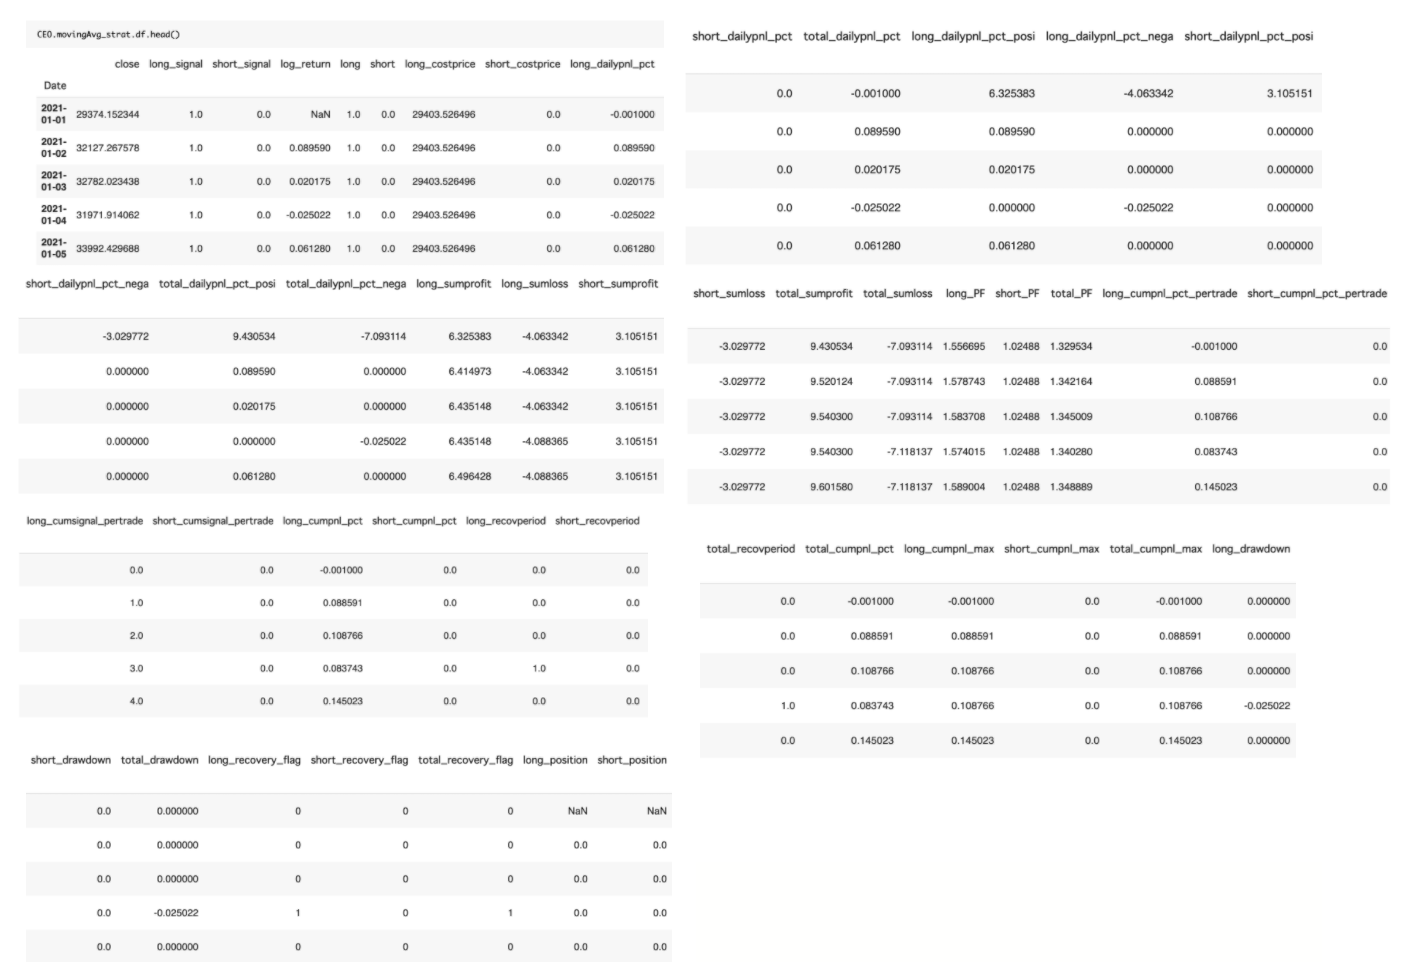

While I do not explain all columns one by one, the summary of the above PnL calculation process is shown as follows.

* First, this agent receives buy/sell signals from quantitative or qualitative agent (column long_signal and short_signal).
* When the long (short) signal turns from 0 to 1, trade starts.
* When any of the following criteria is met, trade is exited.
 - The long (short) signal moves back to 0.
 - Opposite signal arises i.e., when buying, short_signal turns from 0 to 1 and vice versa.
 - The price reaches a certain profit taking or loss cut point. (For example, if the system sets (profit_taking, loss_cut) = (0.2, 0.1), the trade is closed when the price increases by 20% from cost price or the price decreases by -10% from cost price.)

* This agent records cumulative profit of profitable trades and cumulative losses from loss-making trades. Then, this agent calculates “Profit Factor” for long position, short position, and long/short total. (Regarding the Profit Factor, I will explain it later.)

* Also, this agent records “Drawdown”, the loss from its peak performance. (Regarding the details, I will explain later.)

* Transaction cost of buying/selling is assumed as 0.1% of the price for each trade. (Regarding the notion of “transaction cost”, I will explain details later.) 


### Profit Factor

As mentioned, stratPnL() class calculates Profit Factor (PF) of each strategy. From the definition, PF is shown as follows.


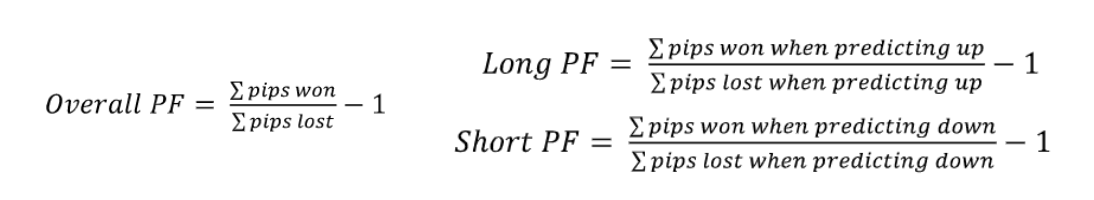

(Source: Rui Pedro Barbosa, Orlando Belo. Algorithmic Trading Using Intelligent Agents, 2008)

* However, in the actual workplace, PF is often calculated just with the gross profit divided by the gross loss (including commissions) for the entire trading period i.e. “-1” in the formula can be omitted and PF can take positive value (if profit is zero and only loss, PF=0. If there are tons of profit with very small loss, PF = very large number).

* To prevent PF taking extremely large values, the system capped PF <= 5.0.

* PF measures the profit per unit of risk, with PF >= 1.0 indicating a profitable trading strategy.

* The system utilize PF as the profitability measurement of each trading strategy (i.e. SMA, Bollinger Bands, and Twitter Sentiment), such that the system determine the weightage of how much we rely on each strategy’s recommendation at Case Based Reasoning in the Decider agent.

### Drawdown

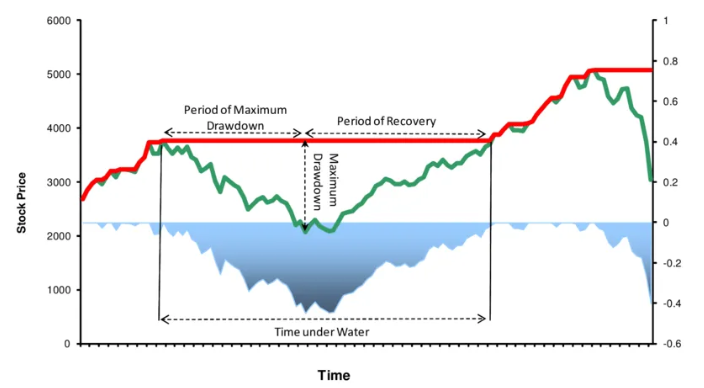

(Source: https://corporatefinanceinstitute.com/resources/knowledge/trading-investing/maximum-drawdown/)

* In the system, stratPnL() class also calculates the “drawdown” of each strategy. 

* “Drawdown” means the amount of loss from its peak performance. 

* “Time under water” a.k.a. “Recovery period” shows total period of time from the day when the fund/strategy began to make a loss from peak, to the day when the fund/strategy could recover its loss (i.e. “going back above water”).  Of course, a shallow drawdown with fewer days of Time Under Water is better for investors, such that industry practitioners in fund industry often check those figures when they evaluate the performance of funds/trading strategies.  

* The stratPnL() class calculates those figures to visualize them into a graph.


### Transaction cost (and its estimation)

* In the PnL calculation for each trading strategy, transaction cost is estimated as 0.1% of the closing price.

* However, formally, the “transaction cost” can be decomposed as follows:

 - Exchange fee (x)
 - Bid-Ask spread / Price (y) 
 - Market impact (MI) i.e. the cost arising from the situation where we should take a more expensive ask than best ask (when buying) and a cheaper bid than best bid (when selling) if the buy/sell amount becomes larger.
 - Opportunity cost (OC) i.e. cost regarding orders not fulfilled.


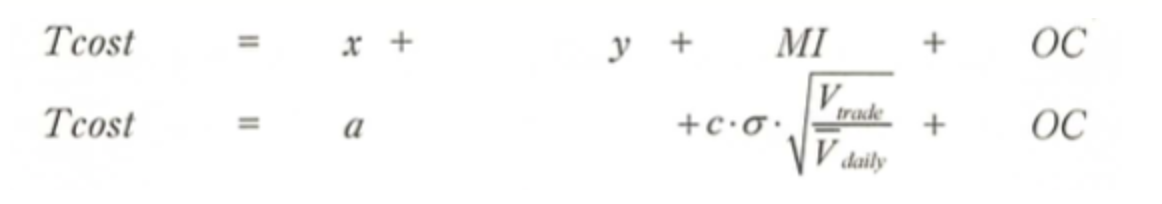

(Source: Barclays Global Investors, Fumio Nakakubo et al., Everything about quantitative active investment: its theory and practice (Written by Japanese), Kinyuu Zaisei Jijo Kenkyukai, 2008)

* However,  as a starting point of learning algorithmic trading, the above estimation sounds too complicated for most small individual investors who do not have to worry so much about market impact cost (i.e. Market Impact cost, Vtrade / Vdaily, is very close to zero for small investors), such that I just simplified the transaction cost as a fixed number of 0.1%.

* Regarding more detailed discussion, please refer final report too.

### Code of the agent

In [ ]:
class stratPnL():
  #Function to calculate profit and loss for each trade under certain levels of profit-taking and stop loss.
  #Transaction cost includes both exchange fee and slippage i.e. the difference between the expected 
  #price of a trade and the price at which the trade is executed. More regorous sense, slippage should be 
  #calculated based on the volatility at the time, but as the initial setting, fixed amount such as 0.1% can 
  #be enough as starting point.

  #initialization of strategy PnL recording book
  def __init__(self, day,take_profit,stop_loss, transaction_cost=0.001,
               test=False, test_initial_df=None):
    
    self.test = test
    self.test_initial_df = test_initial_df
    #We set positionclose signal, current holding, cost price etc as zero.
    columns = ['close','long_signal','short_signal','log_return',
              'long','short','long_costprice','short_costprice',
                'long_dailypnl_pct','short_dailypnl_pct','total_dailypnl_pct',
                'long_dailypnl_pct_posi', 'long_dailypnl_pct_nega',
                'short_dailypnl_pct_posi','short_dailypnl_pct_nega',
                'total_dailypnl_pct_posi','total_dailypnl_pct_nega',
                'long_sumprofit','long_sumloss','short_sumprofit','short_sumloss',
                'total_sumprofit','total_sumloss',
                'long_PF','short_PF','total_PF',
                'long_cumpnl_pct_pertrade','short_cumpnl_pct_pertrade',
                'long_cumsignal_pertrade','short_cumsignal_pertrade',
                'long_cumpnl_pct','short_cumpnl_pct','long_recovperiod',
                'short_recovperiod','total_recovperiod']
    initial_data = np.zeros(len(columns))

    self.df = pd.DataFrame(data=[initial_data],columns=columns)
    self.df.index.names = ['Date']
    self.df = self.df.rename(index={0:day})

    self.take_profit = take_profit
    self.stop_loss = stop_loss
    self.transaction_cost= transaction_cost
    self.profitOrLossTaken = False

  #########################
  #long/short position
  #taking/exit
  #operation functions
  #########################

  def newLongOps(self, day):
    #long position sign = 1
    self.df.loc[day, 'long'] = 1
    #transaction cost is added to the cost price i.e. we should buy higher when we buy.
    self.df.loc[day,'long_costprice'] = self.df.loc[day, 'close'] * (1 + self.transaction_cost)
    self.df.loc[day,'long_dailypnl_pct'] = np.log(self.df.loc[day, 'close'] / self.df.loc[day, 'long_costprice'])
    #using log return, such that cumulative return is just the addition of past.
    self.df.loc[day, 'long_cumpnl_pct_pertrade'] = self.df.loc[day, 'long_dailypnl_pct']

  def newShortOps(self, day):
    self.df.loc[day,'short'] = 1
    #transaction cost is subtracted to the cost price i.e. we should sell lower when we sell.
    self.df.loc[day, 'short_costprice'] = self.df.loc[day, 'close'] * (1 - self.transaction_cost)
    self.df.loc[day, 'short_dailypnl_pct'] = np.log(self.df.loc[day, 'short_costprice'] / self.df.loc[day, 'close'])
    #using log return, such that cumulative return is just the addition of past.
    self.df.loc[day, 'short_cumpnl_pct_pertrade'] = self.df.loc[day, 'short_dailypnl_pct']

  def closeLongOps(self, day, last_day):
    #long position sign = 0
    self.df.loc[day,'long'] = 0
    #reset cost price
    self.df.loc[day,'long_costprice'] = 0
    #Calculate final trading day's performance
    self.df.loc[day,'long_dailypnl_pct'] = self.df.loc[day,'log_return'] - self.transaction_cost
    self.df.loc[day,'long_cumpnl_pct_pertrade'] = self.df.loc[last_day,'long_cumpnl_pct_pertrade']\
                                                  + self.df.loc[day,'long_dailypnl_pct']
    self.df.loc[day,'long_cumsignal_pertrade'] = self.df.loc[last_day,'long_cumsignal_pertrade'] + 1

  def closeShortOps(self, day, last_day):
    #short position sign = 0
    self.df.loc[day, 'short'] = 0
    #reset cost price
    self.df.loc[day, 'short_costprice'] = 0
    #Calculate final trading day's performance
    #It's short selling, so price going down = profit and vice versa.
    self.df.loc[day, 'short_dailypnl_pct'] = - self.df.loc[day, 'log_return'] - self.transaction_cost
    self.df.loc[day,'short_cumpnl_pct_pertrade'] = self.df.loc[last_day,'short_cumpnl_pct_pertrade'] + \
                                                    self.df.loc[day, 'short_dailypnl_pct']
    self.df.loc[day, 'short_cumsignal_pertrade'] = self.df.loc[last_day,'short_cumsignal_pertrade'] + 1

  #########################
  #daily PnL update function
  #########################

  def updateProfitLoss(self, day, signal_hist_df):

    #check last day
    last_day = day + datetime.timedelta(days=-1)
    #default value is zero, then update each figure
    self.df.loc[day,:] = np.zeros(len(self.df.columns))
    #input signal from signaling agent
    daily_signal_df = signal_hist_df.loc[day,:].to_frame().T
    self.df.loc[day,['close','long_signal','short_signal','log_return']]\
    = daily_signal_df.loc[day,['close','long_signal','short_signal','log_return']]

    #if we deal with first row, we skip some operations.
    if self.df.index.get_loc(day) == 0:
      firstRow = True
    else:
      firstRow = False

    #check yesterday's position and today's trading signal
    #then revise long position / short position owning
    if (firstRow == False) and (self.df.loc[last_day,'long'] > 0.5) and (self.df.loc[day,'long_signal'] > 0.5):
      self.df.loc[day,'long'] = 1
    if (firstRow == False) and (self.df.loc[last_day,'short'] > 0.5) and (self.df.loc[day,'short_signal'] > 0.5):
      self.df.loc[day,'short'] = 1

    #When the trading signal turns from 1 to 0, profitOrLossTaken is reset as False
    if (firstRow == False) and (self.df.loc[last_day,'long_signal'] > 0.5) and (self.df.loc[day,'long_signal'] < 0.5):
      self.profitOrLossTaken = False
    if (firstRow == False) and (self.df.loc[last_day,'short_signal'] > 0.5) and (self.df.loc[day,'short_signal'] < 0.5):
      self.profitOrLossTaken = False


    #########################
    #####New Position Taking#####
    #########################

    #When there is no position and takingposition signal arising,
    #start holding crypto position at today's market close.
    if (self.profitOrLossTaken == False) and (self.df.loc[day,'long'] < 0.5) and (self.df.loc[day,'long_signal'] > 0.5):
      
      self.newLongOps(day)
      #if short position owns, closing short position.
      if (firstRow == False) and (self.df.loc[last_day, 'short'] > 0.5):
        self.closeShortOps(day, last_day)

    #When there is no position and short signal arising,
    #start shorting crypto position at today's market close.
    elif (self.profitOrLossTaken == False) and (self.df.loc[day,'short'] < 0.5) and (self.df.loc[day,'short_signal'] > 0.5):
      
      self.newShortOps(day)
      #if long position owns, closing long position.
      if (firstRow == False) and (self.df.loc[day, 'long'] > 0.5):
        self.closeLongOps(day, last_day)

    ##################
    #Position Closing
    ##################
      
    #When position holding exists and reaching stop loss or profit taking point
    #or long_signal/short_signal = -1, position closing
    #long position
    #When position holding exists and reaching stop loss or profit taking point,
    #or long_signal/short_signal = -1, position closing.
    #long position
    elif ((firstRow == False) and (self.df.loc[last_day,'long'] > 0.5)) and \
          ((self.df.loc[last_day,'long_costprice'] * (1 + self.take_profit) < self.df.loc[day,'close']) or
           (self.df.loc[last_day,'long_costprice'] * (1 - self.stop_loss) > self.df.loc[day,'close']) or
           (self.df.loc[day,'long_signal'] < 0.5)):

            #if exiting by profit taking or loss cutting, profitOrLossTaken = True
            #to avoid entering into the market immediate again.
            if ((self.df.loc[last_day,'long_costprice'] * (1 + self.take_profit) < self.df.loc[day,'close']) or 
                (self.df.loc[last_day,'long_costprice'] * (1 - self.stop_loss) > self.df.loc[day,'close'])):

                self.profitOrLossTaken = True

            self.closeLongOps(day, last_day)

    #short position
    elif ((firstRow == False) and(self.df.loc[last_day,'short'] > 0.5)) and \
          ((self.df.loc[last_day,'short_costprice'] * (1 - self.take_profit) > self.df.loc[day,'close']) or
            (self.df.loc[last_day,'short_costprice'] * (1 + self.stop_loss) < self.df.loc[day,'close']) or
            (self.df.loc[day,'short_signal'] < -0.5)):

            #if exiting by profit taking or loss cutting, profitOrLossTaken = True
            #to avoid entering into the market immediate again.
            if ((self.df.loc[last_day,'short_costprice'] * (1 - self.take_profit) > self.df.loc[day,'close']) or 
                (self.df.loc[last_day,'short_costprice'] * (1 + self.stop_loss) < self.df.loc[day,'close'])):

                self.profitOrLossTaken = True
            
            self.closeShortOps(day, last_day)

    ########################
    #Position Continue
    ########################

    #When position holding exists and not reaching stop loss or profit taking point,
    #continue long position.
    elif  (firstRow == False) and (self.df.loc[last_day,'long'] > 0.5):

      self.df.loc[day,'long'] = self.df.loc[last_day,'long']
      self.df.loc[day,'long_costprice'] = self.df.loc[last_day,'long_costprice']
      self.df.loc[day,'long_dailypnl_pct'] = self.df.loc[day,'log_return']
      #using log return, such that cumulative return is just the addition of past.
      self.df.loc[day,'long_cumpnl_pct_pertrade'] = np.multiply([self.df.loc[day,'long_dailypnl_pct'] != 0.0],
                                                        self.df.loc[last_day,'long_cumpnl_pct_pertrade']
                                                         + self.df.loc[day,'long_dailypnl_pct'])
      self.df.loc[day,'long_cumsignal_pertrade'] = np.multiply([self.df.loc[day,'long_dailypnl_pct'] != 0.0],
                                                        self.df.loc[last_day,'long_cumsignal_pertrade'] + 1)

    #continue short position
    elif (firstRow == False) and (self.df.loc[last_day, 'short'] > 0.5):
      self.df.loc[day,'short'] = self.df.loc[last_day,'short']
      self.df.loc[day,'short_costprice'] = self.df.loc[last_day,'short_costprice']
      self.df.loc[day,'short_dailypnl_pct'] = - self.df.loc[day,'log_return']
      #using log return, such that cumulative return is just the addition of past.
      self.df.loc[day,'short_cumpnl_pct_pertrade'] = np.multiply([self.df.loc[day,'short_dailypnl_pct'] != 0.0],
                                                        self.df.loc[last_day,'short_cumpnl_pct_pertrade']
                                                          + self.df.loc[day,'short_dailypnl_pct'])
      self.df.loc[day,'short_cumsignal_pertrade'] = np.multiply([self.df.loc[day,'short_dailypnl_pct'] != 0.0],
                                                        self.df.loc[last_day,'short_cumsignal_pertrade'] + 1)

    ##################
    #update for any cases
    ##################

    #Any cases, update profit factor related columns
    if self.df.loc[day,'long_dailypnl_pct'] >= 0:
      self.df.loc[day,'long_dailypnl_pct_posi'] = self.df.loc[day,'long_dailypnl_pct']
    elif self.df.loc[day,'long_dailypnl_pct'] < 0:
      self.df.loc[day,'long_dailypnl_pct_nega'] = self.df.loc[day,'long_dailypnl_pct']

    if self.df.loc[day,'short_dailypnl_pct'] >= 0:
      self.df.loc[day,'short_dailypnl_pct_posi'] = self.df.loc[day,'short_dailypnl_pct']
    elif self.df.loc[day,'short_dailypnl_pct'] < 0:
      self.df.loc[day,'short_dailypnl_pct_nega'] = self.df.loc[day,'short_dailypnl_pct']

    self.df.loc[day,'total_dailypnl_pct'] = self.df.loc[day,'long_dailypnl_pct'] + \
                                              self.df.loc[day,'short_dailypnl_pct']
    self.df.loc[day,'total_dailypnl_pct_posi'] = self.df.loc[day,'long_dailypnl_pct_posi']\
                                             + self.df.loc[day,'short_dailypnl_pct_posi']
    self.df.loc[day,'total_dailypnl_pct_nega'] = self.df.loc[day,'long_dailypnl_pct_nega']\
                                             + self.df.loc[day,'short_dailypnl_pct_nega']

    #if stratPnL calculation is regarding test data, we intake profit factor (PF)
    #related data from training data.
    if (self.test == True) and (firstRow == True):
      self.df['long_dailypnl_pct_posi'].iloc[0] = self.test_initial_df['long_sumprofit'].iloc[-1]
      self.df['long_dailypnl_pct_nega'].iloc[0] = self.test_initial_df['long_sumloss'].iloc[-1]
      self.df['short_dailypnl_pct_posi'].iloc[0] = self.test_initial_df['short_sumprofit'].iloc[-1]
      self.df['short_dailypnl_pct_nega'].iloc[0] = self.test_initial_df['short_sumloss'].iloc[-1]
      self.df['total_dailypnl_pct_posi'].iloc[0] = self.test_initial_df['total_sumprofit'].iloc[-1]
      self.df['total_dailypnl_pct_nega'].iloc[0] = self.test_initial_df['total_sumloss'].iloc[-1]

    ##################
    #calculation after daily pnl calculation
    ##################

    #Finally, calculating cumulative profit / loss by dailypnl.
    self.df['long_cumpnl_pct'] = self.df['long_dailypnl_pct'].cumsum()
    self.df['short_cumpnl_pct'] = self.df['short_dailypnl_pct'].cumsum()
    self.df['total_cumpnl_pct'] = self.df['long_cumpnl_pct'] + self.df['short_cumpnl_pct']

    #Calculating profit factor
    self.df['long_sumprofit'] = self.df['long_dailypnl_pct_posi'].cumsum()
    self.df['long_sumloss'] = self.df['long_dailypnl_pct_nega'].cumsum()
    self.df['short_sumprofit'] = self.df['short_dailypnl_pct_posi'].cumsum()
    self.df['short_sumloss'] = self.df['short_dailypnl_pct_nega'].cumsum()
    self.df['total_sumprofit'] = self.df['long_sumprofit'] + self.df['short_sumprofit']
    self.df['total_sumloss'] = self.df['long_sumloss'] + self.df['short_sumloss']

    self.df['long_PF'] = self.df['long_sumprofit']/np.abs(self.df['long_sumloss'])
    self.df['short_PF'] = self.df['short_sumprofit']/np.abs(self.df['short_sumloss'])
    self.df['total_PF'] = self.df['total_sumprofit']/np.abs(self.df['total_sumloss'])

    #truncate at 5 if loss is very small and PF is very large
    self.df['long_PF'] = self.df['long_PF'].apply(lambda x: 5 if x > 5 else x)
    self.df['short_PF'] = self.df['short_PF'].apply(lambda x: 5 if x > 5 else x)
    self.df['total_PF'] = self.df['total_PF'].apply(lambda x: 5 if x > 5 else x)
    #fill nan
    self.df['long_PF'] = self.df['long_PF'].fillna(0)
    self.df['short_PF'] = self.df['short_PF'].fillna(0)
    self.df['total_PF'] = self.df['total_PF'].fillna(0)

    #Calculating drawdown by cumulative profit / loss
    self.df['long_cumpnl_max'] = self.df['long_cumpnl_pct'].cummax()
    self.df['short_cumpnl_max'] = self.df['short_cumpnl_pct'].cummax()
    self.df['total_cumpnl_max'] = self.df['total_cumpnl_pct'].cummax()

    self.df['long_drawdown'] = self.df['long_cumpnl_pct'] - self.df['long_cumpnl_max']
    self.df['short_drawdown'] = self.df['short_cumpnl_pct'] - self.df['short_cumpnl_max']
    self.df['total_drawdown'] = self.df['total_cumpnl_pct'] - self.df['total_cumpnl_max']

    #Calculating recovery period
    self.df['long_recovery_flag'] = self.df['long_drawdown'].apply(lambda x: 1 if x < 0.0 else 0)
    self.df['short_recovery_flag'] = self.df['short_drawdown'].apply(lambda x: 1 if x < 0.0 else 0)
    self.df['total_recovery_flag'] = self.df['total_drawdown'].apply(lambda x: 1 if x < 0.0 else 0)

    if firstRow == False:
      self.df.loc[day,'long_recovperiod'] = np.multiply([self.df.loc[day,'long_recovery_flag'] != 0.0],
                                                        self.df.loc[last_day,'long_recovperiod'] + 1)
      self.df.loc[day,'short_recovperiod'] = np.multiply([self.df.loc[day,'short_recovery_flag'] != 0.0],
                                                        self.df.loc[last_day,'short_recovperiod'] + 1)
      self.df.loc[day,'total_recovperiod'] = np.multiply([self.df.loc[day,'total_recovery_flag'] != 0.0],
                                                        self.df.loc[last_day,'total_recovperiod'] + 1)

    #Add long/short position difference to capture start/close date of each position.
    self.df['long_position'] = self.df['long'].diff()
    self.df['short_position'] = self.df['short'].diff()

  ########################
  #Getter functions
  #Those can become interface
  #for communication among
  #different agents
  ########################
  def dfGetter(self):
    return self.df

### Demonstration of the agent

In [ ]:
#read csv file of signal
agent1_hist_signal_df = pd.read_csv('signal_files/agent1_hist_signal_df.csv')
agent1_hist_signal_df.set_index('Date',inplace=True)
agent1_hist_signal_df.index = agent1_hist_signal_df.index.astype('datetime64[ns]')

In [ ]:
agent1_hist_signal_df.head()

,close,long_signal,short_signal,pct_change,log_return
Date,,,,,
2014-09-17,457.334015,0,0,NaN,NaN
2014-09-18,424.440002,0,0,-0.071926,-0.074643
2014-09-19,394.795990,0,0,-0.069843,-0.072402
2014-09-20,408.903992,0,0,0.035735,0.035111
2014-09-21,398.821014,0,0,-0.024659,-0.024968


In [ ]:
#set first day of pnl calculation
day0 = agent1_hist_signal_df.index[0]

In [ ]:
#instantiation of class
strat_test =  stratPnL(day0, 20, 20)

In [ ]:
#it can update daily PnL, using the function of updateProfitLoss.
for day in agent1_hist_signal_df.index:
  strat_test.updateProfitLoss(day, agent1_hist_signal_df)

In [ ]:
#then, we can obtain strategy's PnL
#(in this case, SMA strategy whose buy/sell signals are saved at agent1_hist_signal_df)
strat_test.dfGetter()

,close,long_signal,short_signal,log_return,long,short,long_costprice,short_costprice,long_dailypnl_pct,short_dailypnl_pct,total_dailypnl_pct,long_dailypnl_pct_posi,long_dailypnl_pct_nega,short_dailypnl_pct_posi,short_dailypnl_pct_nega,total_dailypnl_pct_posi,total_dailypnl_pct_nega,long_sumprofit,long_sumloss,short_sumprofit,short_sumloss,total_sumprofit,total_sumloss,long_PF,short_PF,total_PF,long_cumpnl_pct_pertrade,short_cumpnl_pct_pertrade,long_cumsignal_pertrade,short_cumsignal_pertrade,long_cumpnl_pct,short_cumpnl_pct,long_recovperiod,short_recovperiod,total_recovperiod,total_cumpnl_pct,long_cumpnl_max,short_cumpnl_max,total_cumpnl_max,long_drawdown,short_drawdown,total_drawdown,long_recovery_flag,short_recovery_flag,total_recovery_flag,long_position,short_position
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-09-17,457.334015,0.0,0.0,NaN,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,NaN,NaN
2014-09-18,424.440002,0.0,0.0,-0.074643,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0.0,0.0
2014-09-19,394.795990,0.0,0.0,-0.072402,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0.0,0.0
2014-09-20,408.903992,0.0,0.0,0.035111,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0.0,0.0
2014-09-21,398.821014,0.0,0.0,-0.024968,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-13,47793.320312,1.0,0.0,0.073009,1.0,0.0,35385.537687,0.0,0.073009,0.0,0.073009,0.073009,0.000000,0.0,0.0,0.073009,0.000000,19.675442,-13.914767,14.166752,-14.442346,33.842194,-28.357113,1.413997,0.980918,1.193429,0.300583,0.0,19.0,0.0,5.760675,-0.275595,173.0,519.0,173.0,5.485081,6.024286,0.418048,5.817818,-0.263611,-0.693643,-0.332737,1,1,1,0.0,0.0
2021-08-14,47096.945312,1.0,0.0,-0.014678,1.0,0.0,35385.537687,0.0,-0.014678,0.0,-0.014678,0.000000,-0.014678,0.0,0.0,0.000000,-0.014678,19.675442,-13.929444,14.166752,-14.442346,33.842194,-28.371791,1.412507,0.980918,1.192811,0.285905,0.0,20.0,0.0,5.745998,-0.275595,174.0,520.0,174.0,5.470403,6.024286,0.418048,5.817818,-0.278289,-0.693643,-0.347415,1,1,1,0.0,0.0
2021-08-15,47047.003906,1.0,0.0,-0.001061,1.0,0.0,35385.537687,0.0,-0.001061,0.0,-0.001061,0.000000,-0.001061,0.0,0.0,0.000000,-0.001061,19.675442,-13.930505,14.166752,-14.442346,33.842194,-28.372852,1.412400,0.980918,1.192767,0.284844,0.0,21.0,0.0,5.744937,-0.275595,175.0,521.0,175.0,5.469342,6.024286,0.418048,5.817818,-0.279350,-0.693643,-0.348476,1,1,1,0.0,0.0


## Back-testing agent with sliding train/test split

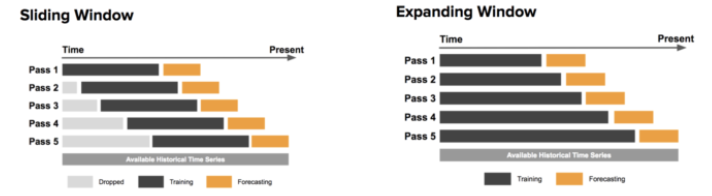

(Source: https://stackoverflow.com/questions/56601488/is-there-a-way-to-get-a-sliding-nested-cross-validation-using-sklearn)

* Then, to implement back-test correctly, we need to implement the "Sliding Window" (aka "Work Forward") shown in the above picture. The system implemented it at class backTest(object).

* **Training data:** By training data, we optimize the parameters of strategy (For example, in SMA, day combination of short-term moving average and long-term moving average) to obtain best return.

* **Test data:** Then, in the test or forecasting period, we check whether an optimized strategy can work in an out-of-sample period. 

* By doing so, we can avoid overfitting to past data and can check whether this strategy can work in the future. Train/test split using sliding windows is important to do back-test and build machine learning models for time-series data. With regard to how to slide train/split windows, there are 2 ways.

 - **Sliding window:** One is the sliding window, shown on the left hand side of the picture below. In this case, both training periods are fixed (i.e. training period: 2 years, test period: 1 year, for example). Then, we slide train/test period.
 - **Expanding window:** The other is the expanding window, shown on the right hand side of the picture below. In this case, the training period spans from the starting time until immediate before the test period. It means that the period of training data becomes longer and longer, as we test recent data.

* While some quants' finance books suggest the expanding window, many industry practitioners and quantitative finance literature apply the sliding window as industry standard. We followed industry standards by applying the sliding window in the system.

### Parameter optimization by sharpe ratio

Next, we should determine the criteria for the parameter optimization.

* **Maximize return?:** One way is just to maximize the return in the training period. For example, we can choose the combination of short-term moving average days and long-term moving average days (like short-term MA = 10 day, long-term MA = 20 days), the combination by which we can maximize the return in the training period and apply those parameters into the test period. 

* **Taking account risk -> Sharpe Ratio:** However, it is not the industry standard. When we consider the return, we also take into account how much we take the risk to obtain this return. In this context, Sharpe Ratio is popularly used in the financial industry to evaluate the performance of certain trading strategies or funds, shown as follows. In the system, def generateBenchmarkComp(df, annualtradedays=365) in class backTest(object) calculates it.

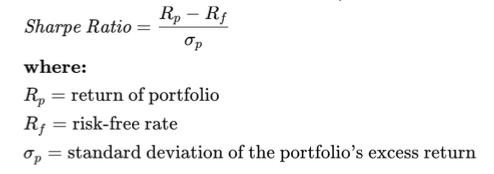

(Source: https://www.investopedia.com/terms/s/sharperatio.asp)

There are some tips and industry customs when we calculate Sharpe ratio.

* **Annual return:** Usually, Rp is stated as an annual return. Just summing up the daily log returns for 1 years, it can become the annual return.

* **Annual volatility:** Also, σp is stated as an annual volatility. By converting daily volatility based on daily % changes into annual volatility, the formula is σ_annual = σ_day*sqrt(trading days for 1 year i.e. 365 in bitcoin's case). When it comes to equity which we do not trade Saturday/Sunday and national holiday, usually 250 days are used i.e. σ_annual = σ_day*sqrt(250).

* **Treatment of Rf:** Risk-free rate can be often omitted and σp can be just calculated as the portfolio’s volatility (not the volatility of the portfolio’s excess return, i.e. σ(Rp - Rf)) in industry custom, because nowadays the risk free rate tends to be low and because the calculation of Rp / σp can be just simpler. By following such industry custom, the system calculates the Sharpe Ratio of trading strategy as Rp / σp, by omitting Rf.

The system optimizes parameters of each strategy to maximize the annualized Sharpe Ratio by greedy search. For example, in SMA strategy, the system tries (short-term MA, long-term MA) = (5,10),(5,20),(10,20) and calculates the sharpe ratio by using each (short-term MA, long-term MA) under training data period. Then, the system applies the parameter with best performance at train data into test data.

### Multi threading

While it is a technical matter, I introduced multi-threading at the implementation of **def
backtestWithSlidingWindow(start,end)** in **class backTest(object)**. By multithreading, the system is able to process multiple threads of codes or functions concurrently.

In algorithmic trading, there can be the situation when we need to run multiple agents together, especially if the data time-horizon becomes shorter than a day, i.e. trading with 5 minutes of price tick data. In such a situation, we can utilize multithreading.

**Note:** Under the Python environment, the system operates each thread just with a single core CPU by switching between threads. So, multithreading by Python may not contribute to the faster operation. Rather, it can become slower due to the additional tasks of switching operations among the working threads. If we would like to implement very short term trading by using minute ticks or shorter, such operational speed can become the issue and we may need to implement the algorithm by Java (faster than Python, but slower than C++) or C++ (faster than Python and Java, but the complexity of implementation can rise and there may not be so much available engineers who can write C++). In the area of HFT (High Frequency Trading) in which the algorithmic system trades equities just by microseconds, mainly C++ or FPGA are used.

### Code of the agent

In [ ]:
class backTest(object):

  #train_size: # of each training dataset, test_size: # of each test dataset.
  #Due to rounding of n_splits calculation and for loop logic below, 
  #actual output size of training dataset and test dataset can be slightly different
  #from train_size and test_size.
  @staticmethod
  def sliding_window(df, train_size, test_size):

    df = df.copy()

    #Calculate n_aplits by the length of dataframe / test_size.
    n_splits = math.floor(len(df) / test_size)
    #Utilize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)
    #Blank list for storing train/test splits.
    splits = []
    for train_index, test_index in tscv.split(df):
      #if the # of data of train_index <= train_size, just storing this train, test split.
      if len(train_index) <= train_size:
          continue
      #if train_index > train_size, truncate data to the train_size.
      else:
          train_index = train_index[-train_size:]
      #store train/test split to the list.
      splits.append([train_index, test_index])

    return splits

  @staticmethod
  def sliding_day_acquisition(splits, df):
    train_test_days = []
    for i in range(0,len(splits)):
      train_test_days.append([df.index[splits[i][0]],df.index[splits[i][1]]])

    return train_test_days

  #calculate and summerize sharpe ratio and buy-and-hold return comparison 
  #from each strategy's pnl dataframe 
  @staticmethod
  def generateBenchmarkComp(df, annualtradedays=365):

    df = df.copy()

    ###domain knowledge###
    #annualtradedays : please input annual trading days. For crypto, it can trade 24/7 and 
    #365 days annually, so input 365. For equity and other asset classes which can be 
    #traded only on Mon.-Fri. excluding public holiday, industry custum is to input 250 days.

    #As a fund industry custum, return, volatility, and sharpe ratio are calculated and 
    #compared based on annualized return and volatility.

    #Market return, volatility, and sharpe ratio
    num_trading_days = len(df)
    market_total_ret = df['log_return'].sum()
    market_annual_avgret = market_total_ret / (num_trading_days/annualtradedays)
    market_volatility = df['log_return'].std()
    market_annualized_volatility = market_volatility * np.sqrt(annualtradedays)
    market_sharpe_ratio = market_annual_avgret / market_annualized_volatility

    #long return, volatility, and sharpe ratio
    long_total_ret = df['long_cumpnl_pct'].iloc[-1]
    long_annual_avgret = long_total_ret / (num_trading_days/annualtradedays)
    long_volatility = df['long_dailypnl_pct'].std()
    long_annualized_volatility = long_volatility * np.sqrt(annualtradedays)
    long_sharpe_ratio = long_annual_avgret / long_annualized_volatility

    #short return, volatility, and sharpe ratio
    short_total_ret = df['short_cumpnl_pct'].iloc[-1]
    short_annual_avgret = short_total_ret / (num_trading_days/annualtradedays)
    short_volatility = df['short_dailypnl_pct'].std()
    short_annualized_volatility = short_volatility * np.sqrt(annualtradedays)
    short_sharpe_ratio = short_annual_avgret / short_annualized_volatility

    #total trading, i.e. both long and short, return, volatility, and sharpe ratio
    total_total_ret = df['total_cumpnl_pct'].iloc[-1]
    total_annual_avgret = total_total_ret / (num_trading_days/annualtradedays)
    total_volatility = df['total_dailypnl_pct'].std()
    total_annualized_volatility = total_volatility * np.sqrt(annualtradedays)
    total_sharpe_ratio = total_annual_avgret / total_annualized_volatility

    return_dict = {'market_total_ret': market_total_ret,
                  'market_annual_ret': market_annual_avgret,
                  'market_annual_volatility': market_annualized_volatility,
                  'market_sharpe_ratio': market_sharpe_ratio,
                  'long_total_ret': long_total_ret,
                  'long_annual_ret': long_annual_avgret,
                  'long_annual_volatility': long_annualized_volatility,
                  'long_sharpe_ratio': long_sharpe_ratio,
                  'short_total_ret': short_total_ret,
                  'short_annual_ret': short_annual_avgret,
                  'short_annual_volatility': short_annualized_volatility,
                  'short_sharpe_ratio': short_sharpe_ratio,
                  'total_total_ret': total_total_ret,
                  'total_annual_ret': total_annual_avgret,
                  'total_annual_volatility': total_annualized_volatility,
                  'total_sharpe_ratio': total_sharpe_ratio
                  }

    return return_dict

  ##################
  #training data's optimization tool
  ##################

  #Optimizing parameters of moving average at training data.
  @staticmethod
  def movingAvgOptimization(train_days_list):

    ########################
    #optimizing parameters related with
    #technical indicator
    ########################

    #parameters for moving average
    ma_list = [5,10,20]
    #for storing sharpe ratio. starting from very low figure,
    #such that new results are updated for optimization
    maxsharpe = -9999
    maxsharpe_combination = [0, 0]
    maxsharpe_df = pd.DataFrame()

    #For each combination of moving average, we implement back-testing.
    #i.e. (st_ma,lt_ma) = (5,10),(5,20),(10,20)
    for (shortMA,longMA) in itertools.combinations(ma_list,2):
      #instantiation of quantsSignal classes
      quantSignal_backtest = quantsSignal(backtest=True)

      for day in train_days_list:
        quantSignal_backtest.movingAvgDailyUpdate(day,shortMA,longMA)
      
      agent1_hist_signal_df = quantSignal_backtest.agent1SignalGetter()
      day0 = agent1_hist_signal_df.index[0]
      #we set take_profit and stop_loss level. (999,999) means no
      #profit take / loss cut by performance.
      strat_optim =  stratPnL(day0, 999, 999)

      for day in agent1_hist_signal_df.index:
        strat_optim.updateProfitLoss(day, agent1_hist_signal_df)

      #check sharpe ratio
      sharpe = backTest.generateBenchmarkComp(strat_optim.dfGetter())['total_sharpe_ratio']

      #check moving avg
      if sharpe > maxsharpe:
        maxsharpe = sharpe
        maxsharpe_combination = [shortMA, longMA]
        maxsharpe_profitloss = [999,999]
        maxsharpe_agent1_hist_signal_df = agent1_hist_signal_df
        maxsharpe_df = strat_optim.dfGetter()

      print("sharpe ratio of moving average [shortMA,longMA] = [{},{}]  without setting profit-taking/losscut: {}"\
            .format(shortMA, longMA, sharpe))

    ########################
    #optimizing profit taking/loss cut level
    ########################

    #After optimizing shortMA and longMA parameters,
    #for each combination of take_profit, stop_loss, we implement back-testing

    tradeexit_list = [0.1,0.2]

    for (take_profit, stop_loss) in itertools.product(tradeexit_list,repeat=2):

      day0 = maxsharpe_agent1_hist_signal_df.index[0]
      #we set take_profit and stop_loss level.
      strat_optim =  stratPnL(day0, take_profit, stop_loss)

      for day in maxsharpe_agent1_hist_signal_df.index:
        strat_optim.updateProfitLoss(day, maxsharpe_agent1_hist_signal_df)

      #check sharpe ratio
      sharpe = backTest.generateBenchmarkComp(strat_optim.dfGetter())['total_sharpe_ratio']

      #check moving avg
      if sharpe > maxsharpe:
        maxsharpe = sharpe
        maxsharpe_profitloss = [take_profit, stop_loss]
        maxsharpe_df = strat_optim.dfGetter()

      print("sharpe ratio of moving average [shortMA,longMA] = [{},{}]  with [profiting, losscut] = [{},{}]: {}"\
            .format(maxsharpe_combination[0], maxsharpe_combination[1], take_profit, stop_loss, sharpe))

    output = [maxsharpe_combination, maxsharpe_profitloss, maxsharpe_df]
    return output

  #Optimize parameters of bollinger band at training data.
  @staticmethod
  def bollingerOptimization(train_days_list):

    ########################
    #optimizing parameters related with
    #technical indicator
    ########################

    #Optimizing parameter list: bollinger band
    datawindow_list = [10,20]
    stddev_list = [2.0, 3.0]

    #for storing sharpe ratio. starting from very low figure,
    #such that new results are updated for optimization
    maxsharpe = -9999
    maxsharpe_combination = [0, 0]
    maxsharpe_df = pd.DataFrame()

    #For each combination of parameters, we implement back-testing.
    for (datawindow,stddev) in itertools.product(datawindow_list,stddev_list):

      #instantiation of quantsSignal
      quantSignal_backtest = quantsSignal(backtest=True)

      for day in train_days_list:
        quantSignal_backtest.bollingerDailyUpdate(day,datawindow,stddev)
      
      agent2_hist_signal_df = quantSignal_backtest.agent2SignalGetter()
      day0 = agent2_hist_signal_df.index[0]
      #we set take_profit and stop_loss level
      strat_optim =  stratPnL(day0, 30, 30)

      for day in agent2_hist_signal_df.index:
        strat_optim.updateProfitLoss(day, agent2_hist_signal_df)

      #check sharpe ratio
      sharpe = backTest.generateBenchmarkComp(strat_optim.dfGetter())['total_sharpe_ratio']
      print("sharpe ratio of bollinger with MA {} and std {}  without setting profit-taking/losscut: {}"\
            .format(datawindow, stddev, sharpe))

      #check whether it's the best ever or not
      if sharpe > maxsharpe:
        maxsharpe = sharpe
        maxsharpe_combination = [datawindow, stddev]
        maxsharpe_profitloss = [30,30]
        maxsharpe_agent2_hist_signal_df = agent2_hist_signal_df
        maxsharpe_df = strat_optim.dfGetter()

    ########################
    #optimizing profit taking/loss cut level
    ########################

    #After optimizing shortMA and longMA parameters,
    #for each combination of take_profit, stop_loss, we implement back-testing

    tradeexit_list = [0.1,0.2]

    for (take_profit, stop_loss) in itertools.product(tradeexit_list,repeat=2):

      day0 = maxsharpe_agent2_hist_signal_df.index[0]
      #we set take_profit and stop_loss level.
      strat_optim =  stratPnL(day0, take_profit, stop_loss)

      for day in maxsharpe_agent2_hist_signal_df.index:
        strat_optim.updateProfitLoss(day, maxsharpe_agent2_hist_signal_df)

      #check sharpe ratio
      sharpe = backTest.generateBenchmarkComp(strat_optim.dfGetter())['total_sharpe_ratio']

      #check moving avg
      if sharpe > maxsharpe:
        maxsharpe = sharpe
        maxsharpe_profitloss = [take_profit, stop_loss]
        maxsharpe_df = strat_optim.dfGetter()

      print("sharpe ratio of bollinger [datawindow,stddev] = [{},{}]  with [profiting, losscut] = [{},{}]: {}"\
            .format(maxsharpe_combination[0], maxsharpe_combination[1], take_profit, stop_loss, sharpe))

    output = [maxsharpe_combination, maxsharpe_profitloss, maxsharpe_df]
    return output

  #Optimize parameters of twitter signal at training data.
  @staticmethod
  def twitterOptimization(train_days_list):

    ########################
    #optimizing parameters related with
    #twitter sentiment
    ########################

    #Optimizing parameter list
    buy_level_list = [40, 45]
    sell_level_list = [20, 25]

    #for storing sharpe ratio. starting from very low figure,
    #such that new results are updated for optimization
    maxsharpe = -9999
    maxsharpe_combination = [0, 0]
    maxsharpe_df = pd.DataFrame()

    #For each combination of parameters, we implement back-testing.
    for (buy_lev, sell_lev) in itertools.product(buy_level_list, sell_level_list):

      #instantiation of twitterSignal classes
      twitterSignal_backtest = twitterSignal(train_days_list[0], backtest=True)

      for day in train_days_list:
        #data window is fixed as 5 day (caz it takes long time)
        twitterSignal_backtest.dailyUpdate(day,5,buy_lev,sell_lev)
      
      agent3_hist_signal_df = twitterSignal_backtest.agent3SignalGetter()
      day0 = agent3_hist_signal_df.index[0]
      #we set take_profit and stop_loss level
      strat_optim =  stratPnL(day0, 999, 999)

      for day in agent3_hist_signal_df.index:
        strat_optim.updateProfitLoss(day, agent3_hist_signal_df)

      #check sharpe ratio
      sharpe = backTest.generateBenchmarkComp(strat_optim.dfGetter())['total_sharpe_ratio']
      print("sharpe ratio of twitter, buying at {}, and selling at {} without setting profit-taking/losscut: {}"\
      .format(buy_lev, sell_lev, sharpe))

      #check whether it's the best ever or not
      if sharpe > maxsharpe:
        maxsharpe = sharpe
        maxsharpe_combination = [buy_lev, sell_lev]
        maxsharpe_profitloss = [999,999]
        maxsharpe_agent3_hist_signal_df = agent3_hist_signal_df
        maxsharpe_df = strat_optim.dfGetter()

    #After optimizing shortMA and longMA parameters,
    #for each combination of take_profit, stop_loss, we implement back-testing

    tradeexit_list = [0.1,0.2]

    for (take_profit, stop_loss) in itertools.product(tradeexit_list,repeat=2):

      day0 = maxsharpe_agent3_hist_signal_df.index[0]
      #we set take_profit and stop_loss level.
      strat_optim =  stratPnL(day0, take_profit, stop_loss)

      for day in maxsharpe_agent3_hist_signal_df.index:
        strat_optim.updateProfitLoss(day, maxsharpe_agent3_hist_signal_df)

      #check sharpe ratio
      sharpe = backTest.generateBenchmarkComp(strat_optim.dfGetter())['total_sharpe_ratio']

      #check moving avg
      if sharpe > maxsharpe:
        maxsharpe = sharpe
        maxsharpe_profitloss = [take_profit, stop_loss]
        maxsharpe_df = strat_optim.dfGetter()

      print("sharpe ratio of twitter [buy_level,sell_level] = [{},{}]  with [profiting, losscut] = [{},{}]: {}"\
            .format(maxsharpe_combination[0], maxsharpe_combination[1], take_profit, stop_loss, sharpe))

    output = [maxsharpe_combination, maxsharpe_profitloss, maxsharpe_df]
    return output

  @staticmethod
  def movingAvgTest(movingAvg_list, test_days_list):
    #instantiation of quantsSignal classes
    quantSignal_backtest = quantsSignal(backtest=True)

    shortMA = movingAvg_list[0][0]
    longMA = movingAvg_list[0][1]
    profit_taking = movingAvg_list[1][0]
    loss_cut = movingAvg_list[1][1]
                              
    for day in test_days_list:
      quantSignal_backtest.movingAvgDailyUpdate(day,shortMA,longMA)

    agent1_hist_signal_df = quantSignal_backtest.agent1SignalGetter()
    day0 = agent1_hist_signal_df.index[0]
    #we set take_profit and stop_loss level from training data
    strat_optim =  stratPnL(day0, profit_taking, loss_cut, test=True, test_initial_df=movingAvg_list[2])

    for day in agent1_hist_signal_df.index:
      strat_optim.updateProfitLoss(day, agent1_hist_signal_df)

    backTest.movingAvgTestResult = strat_optim.dfGetter()

  @staticmethod
  def bollingerTest(bollinger_list, test_days_list):
    #instantiation of quantsSignal classes
    quantSignal_backtest = quantsSignal(backtest=True)

    datawindow = bollinger_list[0][0]
    stddev = bollinger_list[0][1]
    profit_taking = bollinger_list[1][0]
    loss_cut = bollinger_list[1][1]
                              
    for day in test_days_list:
      quantSignal_backtest.bollingerDailyUpdate(day,datawindow,stddev)

    agent2_hist_signal_df = quantSignal_backtest.agent2SignalGetter()
    day0 = agent2_hist_signal_df.index[0]
    #we set take_profit and stop_loss level from training data
    strat_optim =  stratPnL(day0, profit_taking, loss_cut, test=True, test_initial_df=bollinger_list[2])

    for day in agent2_hist_signal_df.index:
      strat_optim.updateProfitLoss(day, agent2_hist_signal_df)

    backTest.bollingerTestResult = strat_optim.dfGetter()

  @staticmethod
  def twitterTest(twitter_list, test_days_list):
    #instantiation of twitterSignal classes
    twitterSignal_backtest = twitterSignal(test_days_list[0], backtest=True)

    buy_level = twitter_list[0][0]
    sell_level = twitter_list[0][1]
    profit_taking = twitter_list[1][0]
    loss_cut = twitter_list[1][1]
                              
    for day in test_days_list:
      twitterSignal_backtest.dailyUpdate(day,5,buy_level,sell_level)

    agent3_hist_signal_df = twitterSignal_backtest.agent3SignalGetter()
    day0 = agent3_hist_signal_df.index[0]
    #we set take_profit and stop_loss level from training data
    strat_optim =  stratPnL(day0, profit_taking, loss_cut, test=True, test_initial_df=twitter_list[2])

    for day in agent3_hist_signal_df.index:
      strat_optim.updateProfitLoss(day, agent3_hist_signal_df)

    backTest.twitterTestResult = strat_optim.dfGetter()

  ####################
  #Whole back-testing process
  #with sliding window
  ####################

  #Function for the re-calculation of cumulative return, drawdown etc
  #After concatenating whole test period results
  @staticmethod
  def reCalculateAfterBackTest(final_outcome_df):
    #Finally, recalculating cumulative profit / loss by dailypnl.
    final_outcome_df['long_cumpnl_pct'] = final_outcome_df['long_dailypnl_pct'].cumsum()
    final_outcome_df['short_cumpnl_pct'] = final_outcome_df['short_dailypnl_pct'].cumsum()
    final_outcome_df['total_cumpnl_pct'] = final_outcome_df['total_dailypnl_pct'].cumsum()

    #recalculating daily pnl for long/short total
    final_outcome_df['total_dailypnl_pct'] = final_outcome_df['long_dailypnl_pct'] + final_outcome_df['short_dailypnl_pct']

    #recalculating drawdown by cumulative profit / loss
    final_outcome_df['long_cumpnl_max'] = final_outcome_df['long_cumpnl_pct'].cummax()
    final_outcome_df['short_cumpnl_max'] = final_outcome_df['short_cumpnl_pct'].cummax()
    final_outcome_df['total_cumpnl_max'] = final_outcome_df['total_cumpnl_pct'].cummax()

    final_outcome_df['long_drawdown'] = final_outcome_df['long_cumpnl_pct'] - final_outcome_df['long_cumpnl_max']
    final_outcome_df['short_drawdown'] = final_outcome_df['short_cumpnl_pct'] - final_outcome_df['short_cumpnl_max']
    final_outcome_df['total_drawdown'] = final_outcome_df['total_cumpnl_pct'] - final_outcome_df['total_cumpnl_max']

    #Calculating recovery period
    final_outcome_df['long_recovery_flag'] = final_outcome_df['long_drawdown'].apply(lambda x: 1 if x < 0.0 else 0)
    final_outcome_df['short_recovery_flag'] = final_outcome_df['short_drawdown'].apply(lambda x: 1 if x < 0.0 else 0)
    final_outcome_df['total_recovery_flag'] = final_outcome_df['total_drawdown'].apply(lambda x: 1 if x < 0.0 else 0)

    for ind in range(1,len(final_outcome_df)):
      final_outcome_df['long_recovperiod'][ind] = np.multiply([final_outcome_df['long_recovery_flag'][ind] != 0.0],
                                                        final_outcome_df['long_recovperiod'][ind-1] + 1)
      final_outcome_df['short_recovperiod'][ind] = np.multiply([final_outcome_df['short_recovery_flag'][ind] != 0.0],
                                                        final_outcome_df['short_recovperiod'][ind-1] + 1)
      final_outcome_df['total_recovperiod'][ind] = np.multiply([final_outcome_df['total_recovery_flag'][ind] != 0.0],
                                                        final_outcome_df['total_recovperiod'][ind-1] + 1)

    #Add long/short position difference to capture start/close date of each position.
    final_outcome_df['long_position'] = final_outcome_df['long'].diff()
    final_outcome_df['short_position'] = final_outcome_df['short'].diff()

    return final_outcome_df

  @staticmethod
  def backtestWithSlidingWindow(start,end):

    #obtain long BTC historical data (2014-2020), then split into train (2 years)
    #and test (1 year) with sliding window
    backtestdata_df = Broker.longHistoryPriceGetter().loc[start:end,:]
    splits = backTest.sliding_window(backtestdata_df, 730, 365)
    train_test_days = backTest.sliding_day_acquisition(splits,Broker.longHistoryPriceGetter())

    #With all sliding windows, implementing optimization at training data 
    #-> taking performance at test data based on optimized parameters
    
    movingAvg_test_finallist = []
    bollinger_test_finallist = []
    twitter_test_finallist = []

    for num_sliding_window in range(len(train_test_days)):

      #obtain train day / test day
      train_days = train_test_days[num_sliding_window][0]
      test_days = train_test_days[num_sliding_window][1]

      #optimization of training data
      opt_movingAvg_list = backTest.movingAvgOptimization(train_days)
      opt_bollinger_list = backTest.bollingerOptimization(train_days)
      opt_twitter_list = backTest.twitterOptimization(train_days)

      #test by test data, using optimized parameters at training data
      thread1 = threading.Thread(target=backTest.movingAvgTest, args=(opt_movingAvg_list, test_days))
      thread2 = threading.Thread(target=backTest.bollingerTest, args=(opt_bollinger_list, test_days))
      thread3 = threading.Thread(target=backTest.twitterTest, args=(opt_twitter_list, test_days))

      thread1.start()
      thread2.start()
      thread3.start()

      thread1.join()
      thread2.join()
      thread3.join()

      #results of training data with optimized parameters
      #and save those as csv files
      movingAvg_trainresult_df = opt_movingAvg_list[2]
      bollinger_trainresult_df = opt_bollinger_list[2]
      twitter_trainresult_df = opt_twitter_list[2]

      movingAvg_trainresult_filename = "movingAvg_trainresult_df_{}.csv".format(num_sliding_window)
      bollinger_trainresult_filename = "bollinger_trainresult_df_{}.csv".format(num_sliding_window)
      twitter_trainresult_filename = "twitter_trainresult_df_{}.csv".format(num_sliding_window)

      #It takes very long time, so save as csv file
      movingAvg_trainresult_df.to_csv('backtest_testresult_data/' + movingAvg_trainresult_filename)
      bollinger_trainresult_df.to_csv('backtest_testresult_data/' + bollinger_trainresult_filename)
      twitter_trainresult_df.to_csv('backtest_testresult_data/' + twitter_trainresult_filename)

      movingAvg_testresult_filename = "movingAvg_testresult_df_{}.csv".format(num_sliding_window)
      bollinger_testresult_filename = "bollinger_testresult_df_{}.csv".format(num_sliding_window)
      twitter_testresult_filename = "twitter_testresult_df_{}.csv".format(num_sliding_window)

      backTest.movingAvgTestResult.to_csv('backtest_testresult_data/' + movingAvg_testresult_filename)
      backTest.bollingerTestResult.to_csv('backtest_testresult_data/' + bollinger_testresult_filename)
      backTest.twitterTestResult.to_csv('backtest_testresult_data/' + twitter_testresult_filename)

      if num_sliding_window == 0:

        #results of test data based on optimized parameters
        movingAvg_testresult_df = backTest.movingAvgTestResult
        bollinger_testresult_df = backTest.bollingerTestResult
        twitter_testresult_df = backTest.twitterTestResult
      else:
        movingAvg_testresult_df = pd.concat([movingAvg_testresult_df,backTest.movingAvgTestResult])
        bollinger_testresult_df = pd.concat([bollinger_testresult_df,backTest.bollingerTestResult])
        twitter_testresult_df = pd.concat([twitter_testresult_df,backTest.twitterTestResult])

    ############################
    #after calculating whole test result,
    #we should re-calculate cumulative return, drawdown etc
    ############################
    #re-calculation of cumulative return, drawdown etc
    movingAvg_testresult_df = backTest.reCalculateAfterBackTest(movingAvg_testresult_df)
    bollinger_testresult_df = backTest.reCalculateAfterBackTest(bollinger_testresult_df)
    twitter_testresult_df = backTest.reCalculateAfterBackTest(twitter_testresult_df)

    #It takes very long time, so save as csv file
    movingAvg_testresult_df.to_csv('backtest_testresult_data/movingAvg_testresult_all_df.csv')
    bollinger_testresult_df.to_csv('backtest_testresult_data/bollinger_testresult_all_df.csv')
    twitter_testresult_df.to_csv('backtest_testresult_data/twitter_testresult_all_df.csv')

  #last 2 years of training
  @staticmethod
  def tradingPrepTraining(start, end):
    final_train_days = Broker.longHistoryPriceGetter().loc[start:end,:].index
    #optimization of training data
    opt_movingAvg_list = backTest.movingAvgOptimization(final_train_days)
    opt_bollinger_list = backTest.bollingerOptimization(final_train_days)
    opt_twitter_list = backTest.twitterOptimization(final_train_days)

    final_training_list = [opt_movingAvg_list,opt_bollinger_list,opt_twitter_list]

    return final_training_list

  #data visualization
  @staticmethod
  def allTestPerformanceGraph(strat_df):

    df = strat_df.copy()

    #set figsize as (10,10)
    fig = plt.figure(figsize=(10,10))
    #set ax for price (larger window) and volume (smaller window)
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0), rowspan=1)

    #plotting closing price, bollinger high band and low band
    ax1.plot(df.index,'close', color='k', data=df)
    # plot buy signals
    ax1.plot(df[df['long_position'] > 0.5].index, 
            df['close'][df['long_position'] > 0.5], 
            '^', markersize = 10, color = 'r', label = 'long')
    # plot sell signals
    ax1.plot(df[df['short_position'] > 0.5].index, 
            df['close'][df['short_position'] > 0.5], 
            '^', markersize = 10, color = 'b', label = 'short')
    ax1.legend()
    ax1.set_title('Test data performance', fontsize=20)
    ax1.set_ylabel('Price', fontsize = 15 )
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%y/%m'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=12))

    #right axis for cumulative profit
    plt2 = ax1.twinx()
    plt2.set_ylabel('Cum. Profit (added %)', fontsize = 15 )
    plt2.plot(df.index,'long_cumpnl_pct', color = 'r', data=df)
    plt2.plot(df.index,'short_cumpnl_pct', color = 'b', data=df)
    plt2.plot(df.index,'total_cumpnl_pct', color = 'g',lw=5, data=df)
    plt2.legend(loc=4)

    ax2.plot(df.index, 'long_drawdown', color = 'r', data=df)
    ax2.plot(df.index, 'short_drawdown', color = 'b', data=df)
    ax2.plot(df.index, 'total_drawdown', color = 'g',lw=5, data=df)
    ax2.set_title('Drawdown by long, short, total', fontsize=20)
    ax2.legend(loc=4)

    fig.tight_layout()
    plt.show()
  
  @staticmethod
  def trainTestperformanceGraph(train_df, test_df):

    train_df = train_df.copy()
    test_df = test_df.copy()
    #set figsize
    fig = plt.figure(figsize=(15,10))
    #set ax for price (larger window) and volume (smaller window)
    ax1 = plt.subplot2grid((3, 2), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 2), (2, 0), rowspan=1)
    #set ax for price (larger window) and volume (smaller window)
    ax3 = plt.subplot2grid((3, 2), (0, 1), rowspan=2)
    ax4 = plt.subplot2grid((3, 2), (2, 1), rowspan=1)

    ##########
    #train data
    ##########

    #plotting closing price, bollinger high band and low band
    ax1.plot(train_df.index,'close', color='k', data=train_df)
    # plot buy signals
    ax1.plot(train_df[train_df['long_position'] > 0.5].index, 
            train_df['close'][train_df['long_position'] > 0.5], 
            '^', markersize = 10, color = 'r', label = 'long')
    # plot sell signals
    ax1.plot(train_df[train_df['short_position'] > 0.5].index, 
            train_df['close'][train_df['short_position'] > 0.5], 
            '^', markersize = 10, color = 'b', label = 'short')
    ax1.legend()
    ax1.set_title('Train data performance', fontsize=20)
    ax1.set_ylabel('Price', fontsize = 10)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%y/%m'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=12))

    #right axis for cumulative profit
    plt2 = ax1.twinx()
    plt2.set_ylabel('Cum. Profit (added %)', fontsize = 15 )
    plt2.plot(train_df.index,'long_cumpnl_pct', color = 'r', data=train_df)
    plt2.plot(train_df.index,'short_cumpnl_pct', color = 'b', data=train_df)
    plt2.plot(train_df.index,'total_cumpnl_pct', color = 'g',lw=5, data=train_df)
    plt2.legend(loc=4)

    ax2.plot(train_df.index, 'long_drawdown', color = 'r', data=train_df)
    ax2.plot(train_df.index, 'short_drawdown', color = 'b', data=train_df)
    ax2.plot(train_df.index, 'total_drawdown', color = 'g',lw=5, data=train_df)
    ax2.set_title('Drawdown by long, short, total', fontsize=20)
    ax2.legend(loc=4)

    ##########
    #test data
    ##########

    #plotting closing price, bollinger high band and low band
    ax3.plot(test_df.index,'close', color='k', data=test_df)
    # plot buy signals
    ax3.plot(test_df[test_df['long_position'] > 0.5].index, 
            test_df['close'][test_df['long_position'] > 0.5], 
            '^', markersize = 10, color = 'r', label = 'long')
    # plot sell signals
    ax3.plot(test_df[test_df['short_position'] > 0.5].index, 
            test_df['close'][test_df['short_position'] > 0.5], 
            '^', markersize = 10, color = 'b', label = 'short')
    ax3.legend()
    ax3.set_title('Test data performance', fontsize=20)
    ax3.set_ylabel('Price', fontsize = 15 )
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%y/%m'))
    ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=12))

    #right axis for cumulative profit
    plt4 = ax3.twinx()
    plt4.set_ylabel('Cum. Profit (added %)', fontsize = 15 )
    plt4.plot(test_df.index,'long_cumpnl_pct', color = 'r', data=test_df)
    plt4.plot(test_df.index,'short_cumpnl_pct', color = 'b', data=test_df)
    plt4.plot(test_df.index,'total_cumpnl_pct', color = 'g', lw=5,data=test_df)
    plt4.legend(loc=4)

    ax4.plot(test_df.index, 'long_drawdown', color = 'r', data=test_df)
    ax4.plot(test_df.index, 'short_drawdown', color = 'b', data=test_df)
    ax4.plot(test_df.index, 'total_drawdown', color = 'g', lw=5, data=test_df)
    ax4.set_title('Drawdown by long, short, total', fontsize=20)
    ax4.legend(loc=4)

    fig.tight_layout()
    plt.show()

  ########################
  #Getter functions
  #Those can become interface
  #for communication among
  #different agents
  ########################

  #No data communication with another agents from backTest agent

In [ ]:
#####################
#Sliding window and performance of test data
#It takes 1-2 hours.
#I've already saved past performance for reference.
#####################

#start = datetime.datetime(2014,1,1)
#end = datetime.datetime(2020,12,31)
#backTest.backtestWithSlidingWindow(start,end)

### Dissection of the agent

#### Broker agent only for taking price of bitcoin

In [ ]:
class Broker(object):

  #get whole price from SQL data library.
  @staticmethod
  def getPriceFromDataLibrary():
    dbConnection = sqlEngine.connect()
    price_df = pd.read_sql("select * from YahooData", dbConnection)
    dbConnection.close()

    price_df = price_df.set_index('Date')[['Close','Volume']]
    price_df.columns = ['close','volume']
    return price_df

  @staticmethod
  def addPctChg(df):
    df = df.copy()
    #calculate % changes
    df['pct_change'] = df['close'].pct_change()
    #In the backtesting, log return is useful, because we can calculate accumulate return %
    #just by adding daily return %. np.log1p calculate log(1+x)
    df['log_return'] = np.log1p(df['pct_change'])

    return df

  @staticmethod
  def histPriceAcquisition():
    longhist_price_df = Broker.getPriceFromDataLibrary()
    #add pct change and log_return
    longhist_price_df = Broker.addPctChg(longhist_price_df)

    #assure all 365 days are within the data index.
    startday = longhist_price_df.index[0]
    endday = longhist_price_df.index[-1]

    date_index = pd.date_range(start = startday, end = endday, freq="D").strftime('%Y-%m-%d')
    date_df = pd.DataFrame(date_index)
    date_df.columns = ['Date']
    date_df['Date'] = pd.to_datetime(date_df['Date']) 
    longhist_price_df = longhist_price_df.reset_index()
    longhist_price_df = date_df.merge(longhist_price_df, on='Date', how='outer')
    #change datetype of Date
    longhist_price_df['Date'] = longhist_price_df['Date'].astype("datetime64")
    #executing ffill (if no price is available, just filling by previous price data)
    longhist_price_df = longhist_price_df.fillna(method='ffill')
    longhist_price_df = longhist_price_df.set_index('Date')

    #Broker.longhist_price_df is created under Broker class.
    Broker.longhist_price_df = longhist_price_df[['close','volume','pct_change','log_return']]

  ########################
  #Getter functions
  ########################

  #Those can become interface
  #for communication among
  #different agents
  @staticmethod
  def longHistoryPriceGetter():
    return Broker.longhist_price_df

In [ ]:
Broker.histPriceAcquisition()

In [ ]:
df = Broker.longHistoryPriceGetter()

In [ ]:
df.head()

,close,volume,pct_change,log_return
Date,,,,
2014-09-17,457.334015,21056800.0,NaN,NaN
2014-09-18,424.440002,34483200.0,-0.071926,-0.074643
2014-09-19,394.795990,37919700.0,-0.069843,-0.072402
2014-09-20,408.903992,36863600.0,0.035735,0.035111
2014-09-21,398.821014,26580100.0,-0.024659,-0.024968


#### Dissection of the agent, mainly referring to def backtestWithSlidingWindow(start,end).

The function of def backtestWithSlidingWindow(start,end) in backTest class handles whole flow of the back-testing using sliding window. So, by referring to this function, we can dissect whole class of backTest.

In [ ]:
def backtestWithSlidingWindow(start,end):

  #obtain long BTC historical data (2014-2020), then split into train (2 years)
  #and test (1 year) with sliding window
  backtestdata_df = Broker.longHistoryPriceGetter().loc[start:end,:]
  splits = backTest.sliding_window(backtestdata_df, 730, 365)
  train_test_days = backTest.sliding_day_acquisition(splits,Broker.longHistoryPriceGetter())

  #With all sliding windows, implementing optimization at training data 
  #-> taking performance at test data based on optimized parameters
  
  movingAvg_test_finallist = []
  bollinger_test_finallist = []
  twitter_test_finallist = []

  for num_sliding_window in range(len(train_test_days)):

    #obtain train day / test day
    train_days = train_test_days[num_sliding_window][0]
    test_days = train_test_days[num_sliding_window][1]

    #optimization of training data
    opt_movingAvg_list = backTest.movingAvgOptimization(train_days)
    opt_bollinger_list = backTest.bollingerOptimization(train_days)
    opt_twitter_list = backTest.twitterOptimization(train_days)

    #test by test data, using optimized parameters at training data
    thread1 = threading.Thread(target=backTest.movingAvgTest, args=(opt_movingAvg_list, test_days))
    thread2 = threading.Thread(target=backTest.bollingerTest, args=(opt_bollinger_list, test_days))
    thread3 = threading.Thread(target=backTest.twitterTest, args=(opt_twitter_list, test_days))

    thread1.start()
    thread2.start()
    thread3.start()

    thread1.join()
    thread2.join()
    thread3.join()

    #results of training data with optimized parameters
    #and save those as csv files
    movingAvg_trainresult_df = opt_movingAvg_list[2]
    bollinger_trainresult_df = opt_bollinger_list[2]
    twitter_trainresult_df = opt_twitter_list[2]

    movingAvg_trainresult_filename = "movingAvg_trainresult_df_{}.csv".format(num_sliding_window)
    bollinger_trainresult_filename = "bollinger_trainresult_df_{}.csv".format(num_sliding_window)
    twitter_trainresult_filename = "twitter_trainresult_df_{}.csv".format(num_sliding_window)

    #It takes very long time, so save as csv file
    movingAvg_trainresult_df.to_csv('backtest_testresult_data/' + movingAvg_trainresult_filename)
    bollinger_trainresult_df.to_csv('backtest_testresult_data/' + bollinger_trainresult_filename)
    twitter_trainresult_df.to_csv('backtest_testresult_data/' + twitter_trainresult_filename)

    movingAvg_testresult_filename = "movingAvg_testresult_df_{}.csv".format(num_sliding_window)
    bollinger_testresult_filename = "bollinger_testresult_df_{}.csv".format(num_sliding_window)
    twitter_testresult_filename = "twitter_testresult_df_{}.csv".format(num_sliding_window)

    backTest.movingAvgTestResult.to_csv('backtest_testresult_data/' + movingAvg_testresult_filename)
    backTest.bollingerTestResult.to_csv('backtest_testresult_data/' + bollinger_testresult_filename)
    backTest.twitterTestResult.to_csv('backtest_testresult_data/' + twitter_testresult_filename)

    if num_sliding_window == 0:

      #results of test data based on optimized parameters
      movingAvg_testresult_df = backTest.movingAvgTestResult
      bollinger_testresult_df = backTest.bollingerTestResult
      twitter_testresult_df = backTest.twitterTestResult
    else:
      movingAvg_testresult_df = pd.concat([movingAvg_testresult_df,backTest.movingAvgTestResult])
      bollinger_testresult_df = pd.concat([bollinger_testresult_df,backTest.bollingerTestResult])
      twitter_testresult_df = pd.concat([twitter_testresult_df,backTest.twitterTestResult])

  ############################
  #after calculating whole test result,
  #we should re-calculate cumulative return, drawdown etc
  ############################
  #re-calculation of cumulative return, drawdown etc
  movingAvg_testresult_df = backTest.reCalculateAfterBackTest(movingAvg_testresult_df)
  bollinger_testresult_df = backTest.reCalculateAfterBackTest(bollinger_testresult_df)
  twitter_testresult_df = backTest.reCalculateAfterBackTest(twitter_testresult_df)

  #It takes very long time, so save as csv file
  movingAvg_testresult_df.to_csv('backtest_testresult_data/movingAvg_testresult_all_df.csv')
  bollinger_testresult_df.to_csv('backtest_testresult_data/bollinger_testresult_all_df.csv')
  twitter_testresult_df.to_csv('backtest_testresult_data/twitter_testresult_all_df.csv')

Reference:

* def backtestWithSlidingWindow(start,end):

#### sklearn only cover "Expanding window", so we need some modification

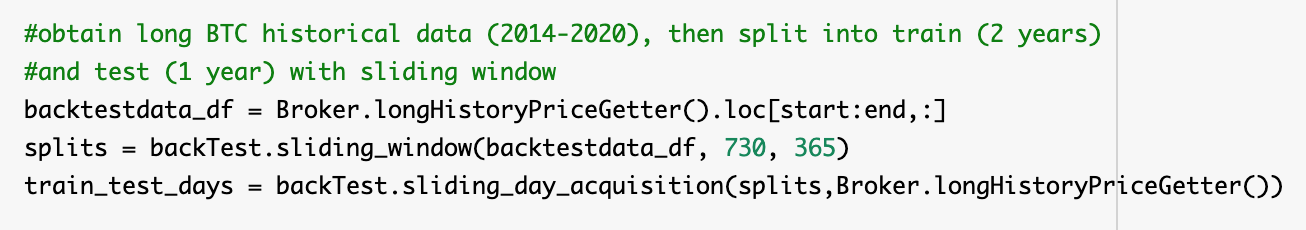

Reference:

* def sliding_window(df, train_size, test_size)
* def sliding_day_acquisition(splits, df)

##### def sliding_window(df, train_size, test_size)

Only with TimeSeriesSplit, we can only do "Expanding Window" shown as above picture and below example.



In [ ]:
#n_splits=5 means that 10 test dataset is created from 101 data.
#Number of train data should be larger than the number of test dataset,
#such that the number of test dataset is set as 9 in this case.
tscv = TimeSeriesSplit(n_splits=10)
splits = []
for train_index, test_index in tscv.split(df.iloc[:100,:]):
  print("TRAIN:", train_index, "\nTEST:", test_index)
  splits.append([train_index, test_index])

TRAIN: [0 1 2 3 4 5 6 7 8 9] 
TEST: [10 11 12 13 14 15 16 17 18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
TEST: [19 20 21 22 23 24 25 26 27]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
TEST: [28 29 30 31 32 33 34 35 36]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36] 
TEST: [37 38 39 40 41 42 43 44 45]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45] 
TEST: [46 47 48 49 50 51 52 53 54]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54] 
TEST: [55 56 57 58 59 60 61 62 63]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 

Below is the modification to implement "Sliding window".

In [ ]:
#train_size: # of each training dataset, test_size: # of each test dataset.
#Due to rounding of n_splits calculation and for loop logic below, 
#actual output size of training dataset and test dataset can be slightly different
#from train_size and test_size.
def sliding_window(df, train_size, test_size):

  df = df.copy()

  #Calculate n_aplits by the length of dataframe / test_size.
  n_splits = math.floor(len(df) / test_size)
  #Utilize TimeSeriesSplit
  tscv = TimeSeriesSplit(n_splits=n_splits)
  #Blank list for storing train/test splits.
  splits = []
  for train_index, test_index in tscv.split(df):
    #if the # of data of train_index <= train_size, just storing this train, test split.
    if len(train_index) <= train_size:
        continue
    #if train_index > train_size, truncate data to the train_size.
    else:
        train_index = train_index[-train_size:]
    #store train/test split to the list.
    splits.append([train_index, test_index])

  return splits

By above code, we can do the sliding window, training period = 730 days and test period = 365 days, shown as follows.

In [ ]:
splits = sliding_window(df, 730, 365)

In [ ]:
splits

[[array([ 353,  354,  355,  356,  357,  358,  359,  360,  361,  362,  363,
          364,  365,  366,  367,  368,  369,  370,  371,  372,  373,  374,
          375,  376,  377,  378,  379,  380,  381,  382,  383,  384,  385,
          386,  387,  388,  389,  390,  391,  392,  393,  394,  395,  396,
          397,  398,  399,  400,  401,  402,  403,  404,  405,  406,  407,
          408,  409,  410,  411,  412,  413,  414,  415,  416,  417,  418,
          419,  420,  421,  422,  423,  424,  425,  426,  427,  428,  429,
          430,  431,  432,  433,  434,  435,  436,  437,  438,  439,  440,
          441,  442,  443,  444,  445,  446,  447,  448,  449,  450,  451,
          452,  453,  454,  455,  456,  457,  458,  459,  460,  461,  462,
          463,  464,  465,  466,  467,  468,  469,  470,  471,  472,  473,
          474,  475,  476,  477,  478,  479,  480,  481,  482,  483,  484,
          485,  486,  487,  488,  489,  490,  491,  492,  493,  494,  495,
          496,  497,  498

##### def sliding_day_acquisition(splits, df)

Next by using def sliding_day_acquisition(splits, df), we can obtain day index for corresponding train/test splits shown as follows.

In [ ]:
def sliding_day_acquisition(splits, df):
  train_test_days = []
  for i in range(0,len(splits)):
    train_test_days.append([df.index[splits[i][0]],df.index[splits[i][1]]])

  return train_test_days

In [ ]:
sliding_day_acquisition(splits, df)

[[DatetimeIndex(['2015-09-05', '2015-09-06', '2015-09-07', '2015-09-08',
                 '2015-09-09', '2015-09-10', '2015-09-11', '2015-09-12',
                 '2015-09-13', '2015-09-14',
                 ...
                 '2017-08-25', '2017-08-26', '2017-08-27', '2017-08-28',
                 '2017-08-29', '2017-08-30', '2017-08-31', '2017-09-01',
                 '2017-09-02', '2017-09-03'],
                dtype='datetime64[ns]', name='Date', length=730, freq=None),
  DatetimeIndex(['2017-09-04', '2017-09-05', '2017-09-06', '2017-09-07',
                 '2017-09-08', '2017-09-09', '2017-09-10', '2017-09-11',
                 '2017-09-12', '2017-09-13',
                 ...
                 '2018-08-21', '2018-08-22', '2018-08-23', '2018-08-24',
                 '2018-08-25', '2018-08-26', '2018-08-27', '2018-08-28',
                 '2018-08-29', '2018-08-30'],
                dtype='datetime64[ns]', name='Date', length=361, freq=None)],
 [DatetimeIndex(['2016-08-31', '2016-

##### (Run above part)

In [ ]:
start = datetime.datetime(2014,1,1)
end = datetime.datetime(2020,12,31)

In [ ]:
#obtain long BTC historical data (2014-2020), then split into train (2 years)
#and test (1 year) with sliding window
backtestdata_df = Broker.longHistoryPriceGetter().loc[start:end,:]
splits = backTest.sliding_window(backtestdata_df, 730, 365)
train_test_days = backTest.sliding_day_acquisition(splits,Broker.longHistoryPriceGetter())

In [ ]:
train_test_days[0]

[DatetimeIndex(['2015-05-31', '2015-06-01', '2015-06-02', '2015-06-03',
                '2015-06-04', '2015-06-05', '2015-06-06', '2015-06-07',
                '2015-06-08', '2015-06-09',
                ...
                '2017-05-20', '2017-05-21', '2017-05-22', '2017-05-23',
                '2017-05-24', '2017-05-25', '2017-05-26', '2017-05-27',
                '2017-05-28', '2017-05-29'],
               dtype='datetime64[ns]', name='Date', length=730, freq=None),
 DatetimeIndex(['2017-05-30', '2017-05-31', '2017-06-01', '2017-06-02',
                '2017-06-03', '2017-06-04', '2017-06-05', '2017-06-06',
                '2017-06-07', '2017-06-08',
                ...
                '2018-04-13', '2018-04-14', '2018-04-15', '2018-04-16',
                '2018-04-17', '2018-04-18', '2018-04-19', '2018-04-20',
                '2018-04-21', '2018-04-22'],
               dtype='datetime64[ns]', name='Date', length=328, freq=None)]

#### Optimization of each trading strategy using training data

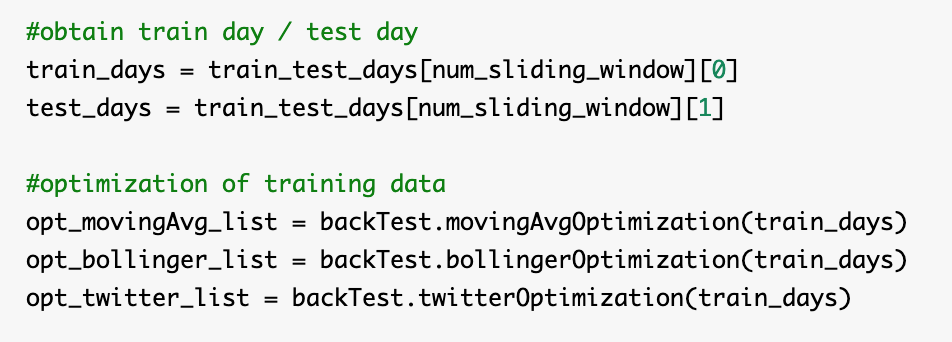

Here, we obtain days in training period and test period

In [ ]:
#now set num_sliding_window = 0.
#For statement iterate num_sliding_window = 1,2,3...
num_sliding_window = 0

In [ ]:
#obtain train day / test day
train_days = train_test_days[num_sliding_window][0]
test_days = train_test_days[num_sliding_window][1]

In [ ]:
train_days

DatetimeIndex(['2015-05-31', '2015-06-01', '2015-06-02', '2015-06-03',
               '2015-06-04', '2015-06-05', '2015-06-06', '2015-06-07',
               '2015-06-08', '2015-06-09',
               ...
               '2017-05-20', '2017-05-21', '2017-05-22', '2017-05-23',
               '2017-05-24', '2017-05-25', '2017-05-26', '2017-05-27',
               '2017-05-28', '2017-05-29'],
              dtype='datetime64[ns]', name='Date', length=730, freq=None)

In [ ]:
test_days

DatetimeIndex(['2017-05-30', '2017-05-31', '2017-06-01', '2017-06-02',
               '2017-06-03', '2017-06-04', '2017-06-05', '2017-06-06',
               '2017-06-07', '2017-06-08',
               ...
               '2018-04-13', '2018-04-14', '2018-04-15', '2018-04-16',
               '2018-04-17', '2018-04-18', '2018-04-19', '2018-04-20',
               '2018-04-21', '2018-04-22'],
              dtype='datetime64[ns]', name='Date', length=328, freq=None)

Then, the code runs the optimization of each strategy in trainig data by executing backTest.movingAvgOptimization(train_days), backTest.bollingerOptimization(train_days), backTest.twitterOptimization(train_days). I will explain how we optimize parameter using training data by backTest.movingAvgOptimization(train_days).

##### Example of training data optimization for simple moving average strategy

First, we need quantitative agent to demonstrate the optimization. Regarding the details of quantsSignal() agent, please refer to the notebook that dissected it.

In [ ]:
class quantsSignal():

  #initialization.
  #backtest=False: day-to-day trading
  #backtest=True: signal for backtest
  def __init__(self,backtest=False):
    self.agent1_hist_signal_df = pd.DataFrame()
    self.agent2_hist_signal_df = pd.DataFrame()
    self.backtest = backtest

  #Function to create moving average.
  def movingAvg(self,df,day, short_term, long_term):
    #rolling short-term moving average
    df['ma_short'] = df['close'].rolling(window=short_term).mean()
    #rolling long-term moving average
    df['ma_long'] = df['close'].rolling(window=long_term).mean()

    #create signal
    #Golden cross -> Buy signal
    df['long_signal'] = np.where(df['ma_short'] > df['ma_long'], 1, 0)

    #Golden cross -> Buy signal
    df['short_signal'] = np.where(df['ma_short'] < df['ma_long'], 1, 0)

    #output only relevant data
    mvgAvg_df = df.loc[day, ['close','long_signal','short_signal']].to_frame().T
    mvgAvg_df.index.names = ['Date']

    #if no prior data, initialize historical signaling dataframe
    if len(self.agent1_hist_signal_df) == 0:
      self.agent1_hist_signal_df = mvgAvg_df
    #else, update data on historical signaling dataframe
    else:
      self.agent1_hist_signal_df = pd.concat([self.agent1_hist_signal_df,
                                                      mvgAvg_df])

    self.agent1_hist_signal_df = Broker.addPctChg(self.agent1_hist_signal_df)
    #for keeping data cleanness, executing elimination of duplicated day data
    self.agent1_hist_signal_df = self.agent1_hist_signal_df[~self.agent1_hist_signal_df.index.duplicated(keep='first')]

  def movingAvgDailyUpdate(self, day, short_term, long_term):
    tMinus50 = day + datetime.timedelta(days=-50)
    df = Broker.longHistoryPriceGetter().loc[tMinus50:day,:]
    self.movingAvg(df,day, short_term, long_term)

  #Function to create bollinger band.
  def bollingerBand(self, df, day, data_window=20, std_dev=2):
    #rolling x days moving average
    df['ma'] = df['close'].rolling(window=data_window).mean()
    #rolling x days standard deviation
    df['std'] = df['close'].rolling(window=data_window).std()
    #bollinger band lower band: x standard deviation from moving average
    df['low_band'] = df['ma'] - df['std'] * std_dev
    #bollinger band higher band: x standard deviation from moving average
    df['high_band'] = df['ma'] + df['std'] * std_dev

    #create trading signal

    #close price go higher than higher band, it's regarded as overbought,
    #such that it's sell signal.
    df['short_signal'] = np.where(df['close'] > df['high_band'], 1, 0)

    #close price go lower than lower band, it's regarded as oversold,
    #such that it's buy signal.
    df['long_signal'] = np.where(df['close'] < df['low_band'], 1, 0)

    #output only relevant data
    bollinger_df = df.loc[day, ['close','long_signal','short_signal']].to_frame().T
    bollinger_df.index.names = ['Date']

    #if no prior data, initialize historical signaling dataframe
    if len(self.agent2_hist_signal_df) == 0:
      self.agent2_hist_signal_df = bollinger_df
    #else, update data on historical signaling dataframe
    else:
      self.agent2_hist_signal_df = pd.concat([self.agent2_hist_signal_df,
                                                      bollinger_df])
      
    self.agent2_hist_signal_df = Broker.addPctChg(self.agent2_hist_signal_df)
    #for keeping data cleanness, executing elimination of duplicated day data
    self.agent2_hist_signal_df = self.agent2_hist_signal_df[~self.agent2_hist_signal_df.index.duplicated(keep='first')]

  def bollingerDailyUpdate(self, day, data_window=20, std_dev=2):
    tMinus50 = day + datetime.timedelta(days=-50)
    df = Broker.longHistoryPriceGetter().loc[tMinus50:day,:]
    self.bollingerBand(df, day, data_window, std_dev)

  ########################
  #Getter functions
  #Those can become interface
  #for communication among
  #different agents
  ########################
  def agent1SignalGetter(self):
    return self.agent1_hist_signal_df

  def agent2SignalGetter(self):
    return self.agent2_hist_signal_df

Then, please see below code of movingAvgOptimization(train_days_list).

In [ ]:
#Optimizing parameters of moving average at training data.
def movingAvgOptimization(train_days_list):

  ########################
  #optimizing parameters related with
  #technical indicator
  ########################

  #parameters for moving average
  ma_list = [5,10,20]
  #for storing sharpe ratio. starting from very low figure,
  #such that new results are updated for optimization
  maxsharpe = -9999
  maxsharpe_combination = [0, 0]
  maxsharpe_df = pd.DataFrame()

  #For each combination of moving average, we implement back-testing.
  #i.e. (st_ma,lt_ma) = (5,10),(5,20),(10,20)
  for (shortMA,longMA) in itertools.combinations(ma_list,2):
    #instantiation of quantsSignal classes
    quantSignal_backtest = quantsSignal(backtest=True)

    for day in train_days_list:
      quantSignal_backtest.movingAvgDailyUpdate(day,shortMA,longMA)
    
    agent1_hist_signal_df = quantSignal_backtest.agent1SignalGetter()
    day0 = agent1_hist_signal_df.index[0]
    #we set take_profit and stop_loss level. (999,999) means no
    #profit take / loss cut by performance.
    strat_optim =  stratPnL(day0, 999, 999)

    for day in agent1_hist_signal_df.index:
      strat_optim.updateProfitLoss(day, agent1_hist_signal_df)

    #check sharpe ratio
    sharpe = backTest.generateBenchmarkComp(strat_optim.dfGetter())['total_sharpe_ratio']

    #check moving avg
    if sharpe > maxsharpe:
      maxsharpe = sharpe
      maxsharpe_combination = [shortMA, longMA]
      maxsharpe_profitloss = [999,999]
      maxsharpe_agent1_hist_signal_df = agent1_hist_signal_df
      maxsharpe_df = strat_optim.dfGetter()

    print("sharpe ratio of moving average [shortMA,longMA] = [{},{}]  without setting profit-taking/losscut: {}"\
          .format(shortMA, longMA, sharpe))

  ########################
  #optimizing profit taking/loss cut level
  ########################

  #After optimizing shortMA and longMA parameters,
  #for each combination of take_profit, stop_loss, we implement back-testing

  tradeexit_list = [0.1,0.2]

  for (take_profit, stop_loss) in itertools.product(tradeexit_list,repeat=2):

    day0 = maxsharpe_agent1_hist_signal_df.index[0]
    #we set take_profit and stop_loss level.
    strat_optim =  stratPnL(day0, take_profit, stop_loss)

    for day in maxsharpe_agent1_hist_signal_df.index:
      strat_optim.updateProfitLoss(day, maxsharpe_agent1_hist_signal_df)

    #check sharpe ratio
    sharpe = backTest.generateBenchmarkComp(strat_optim.dfGetter())['total_sharpe_ratio']

    #check moving avg
    if sharpe > maxsharpe:
      maxsharpe = sharpe
      maxsharpe_profitloss = [take_profit, stop_loss]
      maxsharpe_df = strat_optim.dfGetter()

    print("sharpe ratio of moving average [shortMA,longMA] = [{},{}]  with [profiting, losscut] = [{},{}]: {}"\
          .format(maxsharpe_combination[0], maxsharpe_combination[1], take_profit, stop_loss, sharpe))

  output = [maxsharpe_combination, maxsharpe_profitloss, maxsharpe_df]
  return output

* First, we set parameter lists for greedy search. This time, ma_list = [5,10,20] are the set for moving averages as the search space.

* maxsharpe = -9999 is for the recording purpose. if the backtest result of sharpe ratio is better than this (absolutely better than this in any case), it's updated with the best performed. As such, we can obtain the best result after finishing For-loop.

* maxsharpe_combination means [short_MA, long_MA] combinaion when the sharpe ratio is the best performing. we can obtain the best performing combination of [short_MA, long_MA] after finishing For-loop.

* maxsharpe_df is the dataframe of pnl when the sharpe ratio is the best performing. We can obtain the best performing PnL dataframe after finishing For-loop.

In [ ]:
  ########################
  #optimizing parameters related with
  #technical indicator
  ########################

  #parameters for moving average
  ma_list = [5,10,20]
  #for storing sharpe ratio. starting from very low figure,
  #such that new results are updated for optimization
  maxsharpe = -9999
  maxsharpe_combination = [0, 0]
  maxsharpe_df = pd.DataFrame()

itertools.combinations(ma_list,2) returns combination shown as follows. It's convenient to implement loop such as this time, so we can utilize it.

In [ ]:
for i in itertools.combinations(ma_list,2):
  print(i)

(5, 10)
(5, 20)
(10, 20)


By below, we can find optimum combination of [shortMA, longMA] from the combination of [5,10],[5,20],[10,20], the combination which results the best sharpe ratio. The function of def generateBenchmarkComp(df, annualtradedays=365) can obtain the sharpe ratio at the time.

In [ ]:
train_days_list = train_days

In [ ]:
  #For each combination of moving average, we implement back-testing.
  #i.e. (st_ma,lt_ma) = (5,10),(5,20),(10,20)
  for (shortMA,longMA) in itertools.combinations(ma_list,2):
    #instantiation of quantsSignal classes
    quantSignal_backtest = quantsSignal(backtest=True)

    for day in train_days_list:
      quantSignal_backtest.movingAvgDailyUpdate(day,shortMA,longMA)
    
    agent1_hist_signal_df = quantSignal_backtest.agent1SignalGetter()
    day0 = agent1_hist_signal_df.index[0]
    #we set take_profit and stop_loss level. (999,999) means no
    #profit take / loss cut by performance.
    strat_optim =  stratPnL(day0, 999, 999)

    for day in agent1_hist_signal_df.index:
      strat_optim.updateProfitLoss(day, agent1_hist_signal_df)

    #check sharpe ratio
    sharpe = backTest.generateBenchmarkComp(strat_optim.dfGetter())['total_sharpe_ratio']

    #check moving avg
    if sharpe > maxsharpe:
      maxsharpe = sharpe
      maxsharpe_combination = [shortMA, longMA]
      maxsharpe_profitloss = [999,999]
      maxsharpe_agent1_hist_signal_df = agent1_hist_signal_df
      maxsharpe_df = strat_optim.dfGetter()

    print("sharpe ratio of moving average [shortMA,longMA] = [{},{}]  without setting profit-taking/losscut: {}"\
          .format(shortMA, longMA, sharpe))

sharpe ratio of moving average [shortMA,longMA] = [5,10]  without setting profit-taking/losscut: 1.686574680960185
sharpe ratio of moving average [shortMA,longMA] = [5,20]  without setting profit-taking/losscut: 1.510408810854585
sharpe ratio of moving average [shortMA,longMA] = [10,20]  without setting profit-taking/losscut: 1.0992397483120397


Then, by fixing [shortMA, longMA] as the best performing one i.e. in above case, [5,10] with the sharpe ratio of 1.6865, next we optimize the parameter of profit-taking and loss-cut level by following code.

itertools.product will return cartesian product as follows. It is also useful in many occasion, such that we can utilize it.

In [ ]:
tradeexit_list = [0.1,0.2]

for (i,j) in itertools.product(tradeexit_list,repeat=2):
  print(i,j)

0.1 0.1
0.1 0.2
0.2 0.1
0.2 0.2


In [ ]:
########################
#optimizing profit taking/loss cut level
########################

#After optimizing shortMA and longMA parameters,
#for each combination of take_profit, stop_loss, we implement back-testing

tradeexit_list = [0.1,0.2]

for (take_profit, stop_loss) in itertools.product(tradeexit_list,repeat=2):

  day0 = maxsharpe_agent1_hist_signal_df.index[0]
  #we set take_profit and stop_loss level.
  strat_optim =  stratPnL(day0, take_profit, stop_loss)

  for day in maxsharpe_agent1_hist_signal_df.index:
    strat_optim.updateProfitLoss(day, maxsharpe_agent1_hist_signal_df)

  #check sharpe ratio
  sharpe = backTest.generateBenchmarkComp(strat_optim.dfGetter())['total_sharpe_ratio']

  #check moving avg
  if sharpe > maxsharpe:
    maxsharpe = sharpe
    maxsharpe_profitloss = [take_profit, stop_loss]
    maxsharpe_df = strat_optim.dfGetter()

  print("sharpe ratio of moving average [shortMA,longMA] = [{},{}]  with [profiting, losscut] = [{},{}]: {}"\
        .format(maxsharpe_combination[0], maxsharpe_combination[1], take_profit, stop_loss, sharpe))

output = [maxsharpe_combination, maxsharpe_profitloss, maxsharpe_df]

sharpe ratio of moving average [shortMA,longMA] = [5,10]  with [profiting, losscut] = [0.1,0.1]: 1.2828411433439793
sharpe ratio of moving average [shortMA,longMA] = [5,10]  with [profiting, losscut] = [0.1,0.2]: 1.3181341589508888
sharpe ratio of moving average [shortMA,longMA] = [5,10]  with [profiting, losscut] = [0.2,0.1]: 1.5636688871790334
sharpe ratio of moving average [shortMA,longMA] = [5,10]  with [profiting, losscut] = [0.2,0.2]: 1.5910527310891336


In [ ]:
output

[[5, 10],
 [999, 999],
                   close  long_signal  ...  long_position  short_position
 Date                                  ...                               
 2015-05-31   230.190002          0.0  ...            NaN             NaN
 2015-06-01   222.925995          0.0  ...            0.0             0.0
 2015-06-02   225.802994          0.0  ...            0.0             0.0
 2015-06-03   225.873993          0.0  ...            0.0             0.0
 2015-06-04   224.324005          0.0  ...            0.0             0.0
 ...                 ...          ...  ...            ...             ...
 2017-05-25  2304.979980          1.0  ...            0.0             0.0
 2017-05-26  2202.419922          1.0  ...            0.0             0.0
 2017-05-27  2038.869995          1.0  ...            0.0             0.0
 2017-05-28  2155.800049          1.0  ...            0.0             0.0
 2017-05-29  2255.610107          0.0  ...           -1.0             1.0
 
 [730 rows x 

With regard to bollinger bands and twitter signal, basically those are optimized in a same manner. [5,10] is the combination of optimal parameters. [999,999] means the optimal combination of profit-taking and loss-cut. 999 means that no profit-taking and loss-cut rule and just let SMA signal showing at golden/death cross worked the best in this training period.

#### Application of optimized parameters at training data into test data

Then, we apply optimized parameters at training data, into test data.

Regarding the multi-threading, I explained how it works in another notebook of Multithread_Example.ipynb, so please refer to it. Here, I explain how backTest.movingAvgTest works.

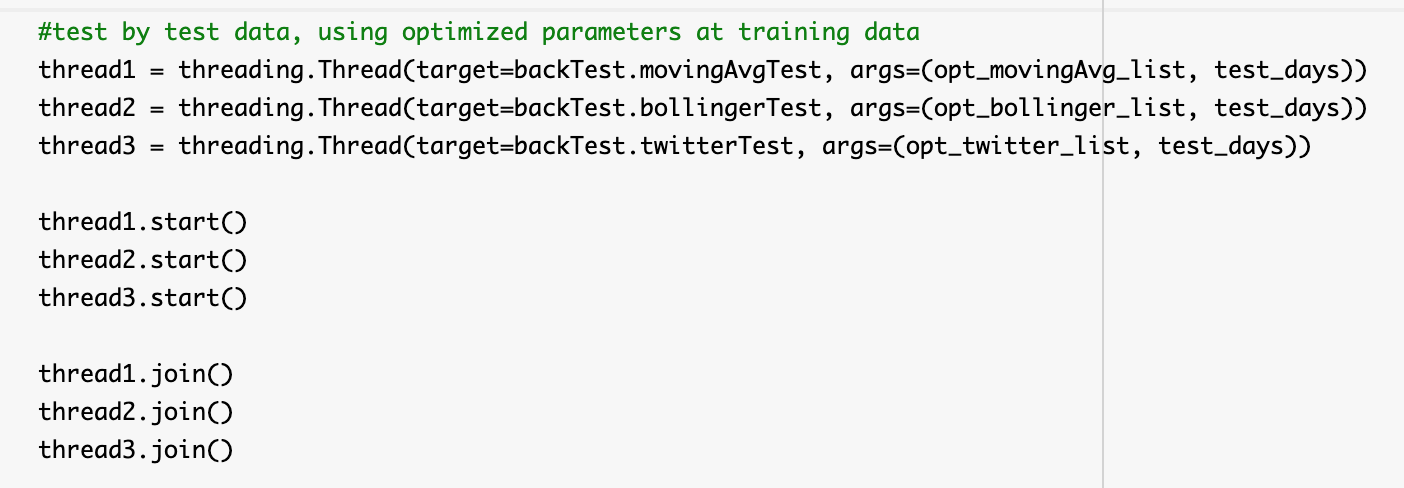

By running below def movingAvgTest(movingAvg_list, test_days_list), it intake the best parameters at training data period and apply those into test data period, then calculate PnL in test period.

In [ ]:
movingAvg_list = output
test_days_list = test_days

In [ ]:
def movingAvgTest(movingAvg_list, test_days_list):
  #instantiation of quantsSignal classes
  quantSignal_backtest = quantsSignal(backtest=True)

  shortMA = movingAvg_list[0][0]
  longMA = movingAvg_list[0][1]
  profit_taking = movingAvg_list[1][0]
  loss_cut = movingAvg_list[1][1]
                            
  for day in test_days_list:
    quantSignal_backtest.movingAvgDailyUpdate(day,shortMA,longMA)

  agent1_hist_signal_df = quantSignal_backtest.agent1SignalGetter()
  day0 = agent1_hist_signal_df.index[0]
  #we set take_profit and stop_loss level from training data
  strat_optim =  stratPnL(day0, profit_taking, loss_cut, test=True, test_initial_df=movingAvg_list[2])

  for day in agent1_hist_signal_df.index:
    strat_optim.updateProfitLoss(day, agent1_hist_signal_df)

  backTest.movingAvgTestResult = strat_optim.dfGetter()

In [ ]:
movingAvgTest(movingAvg_list, test_days_list)

In [ ]:
backTest.movingAvgTestResult

,close,long_signal,short_signal,log_return,long,short,long_costprice,short_costprice,long_dailypnl_pct,short_dailypnl_pct,total_dailypnl_pct,long_dailypnl_pct_posi,long_dailypnl_pct_nega,short_dailypnl_pct_posi,short_dailypnl_pct_nega,total_dailypnl_pct_posi,total_dailypnl_pct_nega,long_sumprofit,long_sumloss,short_sumprofit,short_sumloss,total_sumprofit,total_sumloss,long_PF,short_PF,total_PF,long_cumpnl_pct_pertrade,short_cumpnl_pct_pertrade,long_cumsignal_pertrade,short_cumsignal_pertrade,long_cumpnl_pct,short_cumpnl_pct,long_recovperiod,short_recovperiod,total_recovperiod,total_cumpnl_pct,long_cumpnl_max,short_cumpnl_max,total_cumpnl_max,long_drawdown,short_drawdown,total_drawdown,long_recovery_flag,short_recovery_flag,total_recovery_flag,long_position,short_position
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-05-30,2175.469971,0.0,1.0,NaN,0.0,1.0,0.000000,2173.294501,0.000000,-0.001001,-0.001001,5.240030,-2.916989,2.295775,-2.724001,7.535805,-5.640990,5.240030,-2.916989,2.295775,-2.724001,7.535805,-5.640990,1.796383,0.842795,1.335901,0.000000,-0.001001,0.0,0.0,0.000000,-0.001001,0.0,0.0,0.0,-0.001001,0.000000,-0.001001,-0.001001,0.000000,0.000000,0.000000,0,0,0,NaN,NaN
2017-05-31,2286.409912,0.0,1.0,0.049738,0.0,1.0,0.000000,2173.294501,0.000000,-0.049738,-0.049738,0.000000,0.000000,0.000000,-0.049738,0.000000,-0.049738,5.240030,-2.916989,2.295775,-2.773739,7.535805,-5.690728,1.796383,0.827682,1.324225,0.000000,-0.050739,0.0,1.0,0.000000,-0.050739,0.0,1.0,1.0,-0.050739,0.000000,-0.001001,-0.001001,0.000000,-0.049738,-0.049738,0,1,1,0.0,0.0
2017-06-01,2407.879883,0.0,1.0,0.051764,0.0,1.0,0.000000,2173.294501,0.000000,-0.051764,-0.051764,0.000000,0.000000,0.000000,-0.051764,0.000000,-0.051764,5.240030,-2.916989,2.295775,-2.825503,7.535805,-5.742492,1.796383,0.812519,1.312288,0.000000,-0.102502,0.0,2.0,0.000000,-0.102502,0.0,2.0,2.0,-0.102502,0.000000,-0.001001,-0.001001,0.000000,-0.101502,-0.101502,0,1,1,0.0,0.0
2017-06-02,2488.550049,1.0,0.0,0.032954,1.0,0.0,2491.038599,0.000000,-0.001000,-0.033954,-0.034953,0.000000,-0.001000,0.000000,-0.033954,0.000000,-0.034953,5.240030,-2.917988,2.295775,-2.859456,7.535805,-5.777445,1.795768,0.802871,1.304349,-0.001000,-0.136456,0.0,3.0,-0.001000,-0.136456,1.0,3.0,3.0,-0.137456,0.000000,-0.001001,-0.001001,-0.001000,-0.135456,-0.136455,1,1,1,1.0,-1.0
2017-06-03,2515.350098,1.0,0.0,0.010712,1.0,0.0,2491.038599,0.000000,0.010712,0.000000,0.010712,0.010712,0.000000,0.000000,0.000000,0.010712,0.000000,5.250742,-2.917988,2.295775,-2.859456,7.546517,-5.777445,1.799439,0.802871,1.306203,0.009712,0.000000,1.0,0.0,0.009712,-0.136456,0.0,4.0,4.0,-0.126744,0.009712,-0.001001,-0.001001,0.000000,-0.135456,-0.125743,0,1,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-18,8163.419922,1.0,0.0,0.032536,1.0,0.0,7897.139250,0.000000,0.032536,0.000000,0.032536,0.032536,0.000000,0.000000,0.000000,0.032536,0.000000,9.069926,-5.381945,5.193240,-6.216279,14.263165,-11.598224,1.685251,0.835426,1.229772,0.033163,0.000000,6.0,0.0,1.364940,-0.595814,123.0,323.0,57.0,0.769126,1.753556,-0.001001,1.069110,-0.388616,-0.594813,-0.299984,1,1,1,0.0,0.0
2018-04-19,8294.309570,1.0,0.0,0.015906,1.0,0.0,7897.139250,0.000000,0.015906,0.000000,0.015906,0.015906,0.000000,0.000000,0.000000,0.015906,0.000000,9.085832,-5.381945,5.193240,-6.216279,14.279072,-11.598224,1.688206,0.835426,1.231143,0.049069,0.000000,7.0,0.0,1.380846,-0.595814,124.0,324.0,58.0,0.785032,1.753556,-0.001001,1.069110,-0.372709,-0.594813,-0.284078,1,1,1,0.0,0.0
2018-04-20,8845.830078,1.0,0.0,0.064376,1.0,0.0,7897.139250,0.000000,0.064376,0.000000,0.064376,0.064376,0.000000,0.000000,0.000000,0.064376,0.000000,9.150209,-5.381945,5.193240,-6.216279,14.343448,-11.598224,1.700168,0.835426,1.236694,0.113446,0.000000,8.0,0.0,1.445223,-0.595814,125.0,325.0,59.0,0.849409,1.753556,-0.001001,1.069

Bollinger Bands and Twitter sentiment are operated by same manner.

### Summary of strategies, each traing and test period

* Below are the examples of performance in the training period and test period with 4 sets of sliding windows for the SMA strategy.

* **Train/test split:** Former 2 years of data is used as a training period to optimize parameters of short term moving average and long term moving average. Also, with the optimized parameters, the last 1 year is traded as a test period.

* **Sliding window:** Then, the system slides a dataset of 2 years of training data and 1 year of test data, by 1 year ahead.

* **Result:** As you can see, in the training data period on the left hand side of the graph, the performance is great i.e. total cumulative profit of the green line goes upward in a constant manner because it is the performance with the optimized parameters after try-and-errors by greedy search. However, in the test data period on the right hand side, the performance is not as great as was in the training data period.

* **Traders' dilemma...Overfitting:** Such result shows typical reality in algorithmic trading. Many traders optimize the parameter by past data such that the back-testing performance i.e. training data’s performance looks great. However, in reality, when we apply the optimized parameter into future data for real trading, the performance cannot be as good as was in the test data. It is a popular phenomena called “overfitting” toward training data. Many trading systems just show great performance in the training data period, but most of them cannot be reproducible in the real trading for the future coming data.

* **Where is holy grail?:** Searching for the robust trading model which shows constant performance in the both training and test period can be the important theme for the quantitative researchers, while it is very challenging.

##### SMA strategy

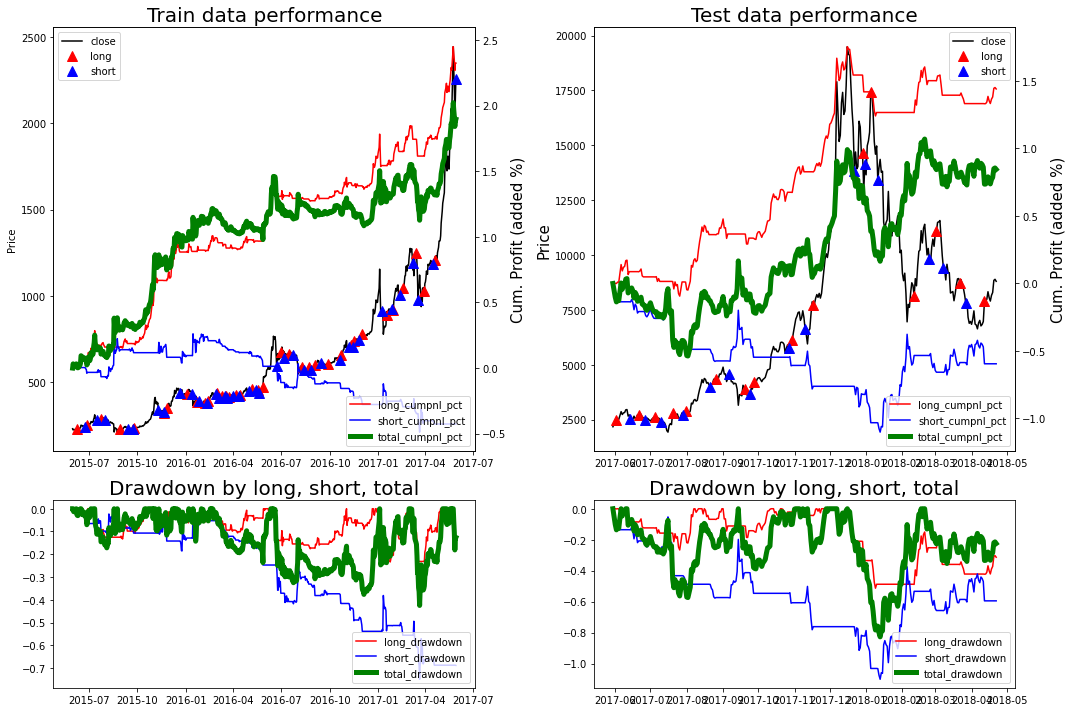

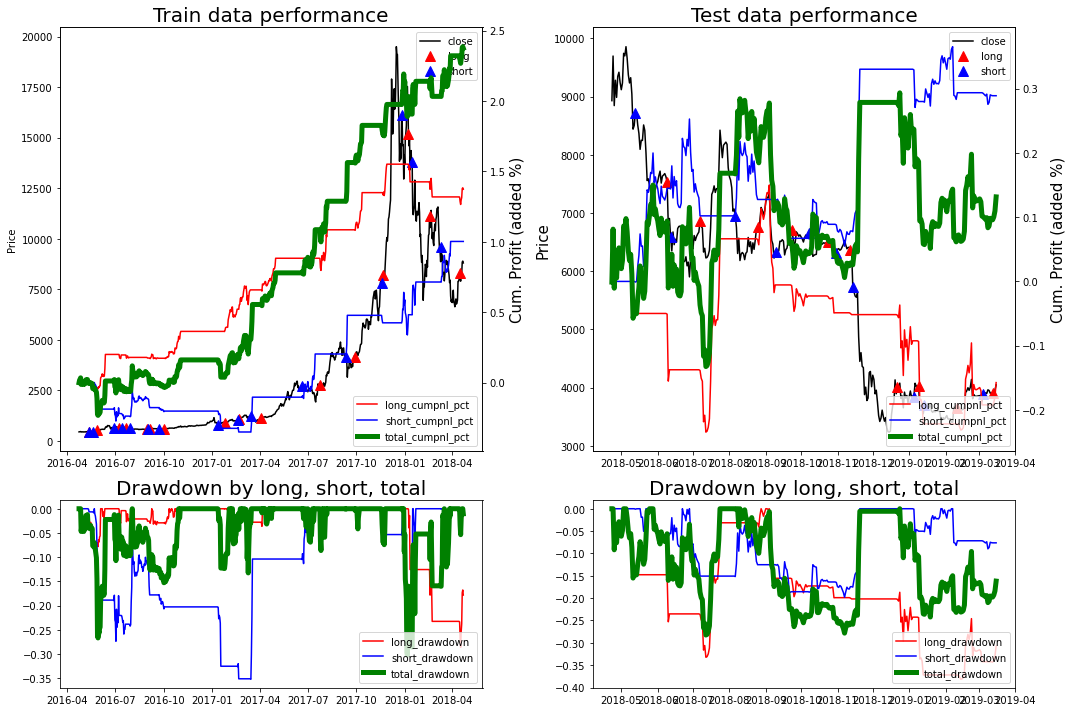

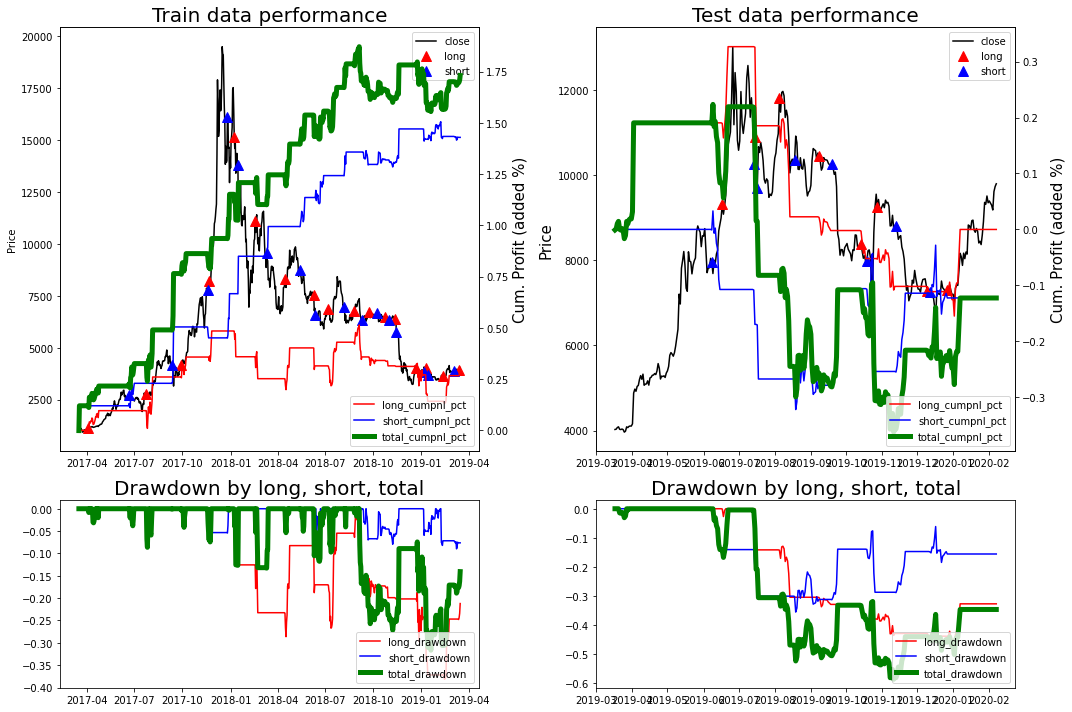

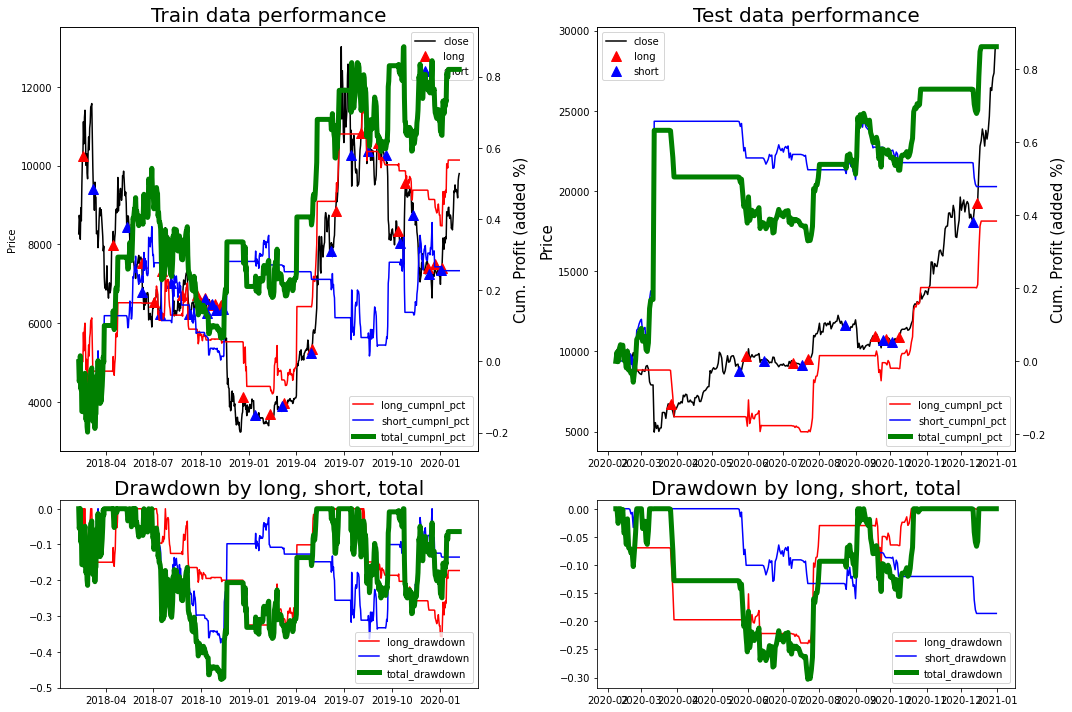

In [ ]:
for i in range(0,4):
  movingAvg_trainresult_df = pd.read_csv('backtest_testresult_data/movingAvg_trainresult_df_{}.csv'.format(i))
  movingAvg_trainresult_df = movingAvg_trainresult_df.set_index('Date')
  movingAvg_trainresult_df.index = pd.to_datetime(movingAvg_trainresult_df.index)

  movingAvg_testresult_df = pd.read_csv('backtest_testresult_data/movingAvg_testresult_df_{}.csv'.format(i))
  movingAvg_testresult_df = movingAvg_testresult_df.set_index('Date')
  movingAvg_testresult_df.index = pd.to_datetime(movingAvg_testresult_df.index)

  backTest.trainTestperformanceGraph(movingAvg_trainresult_df, movingAvg_testresult_df)

##### Bollinger Bands strategy

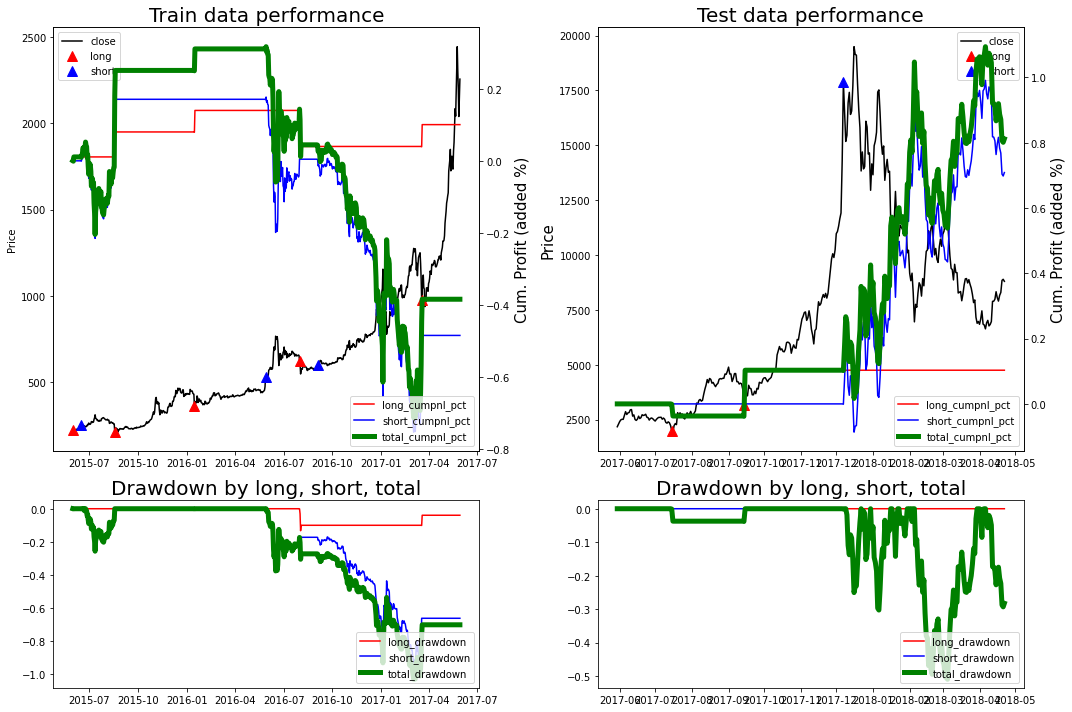

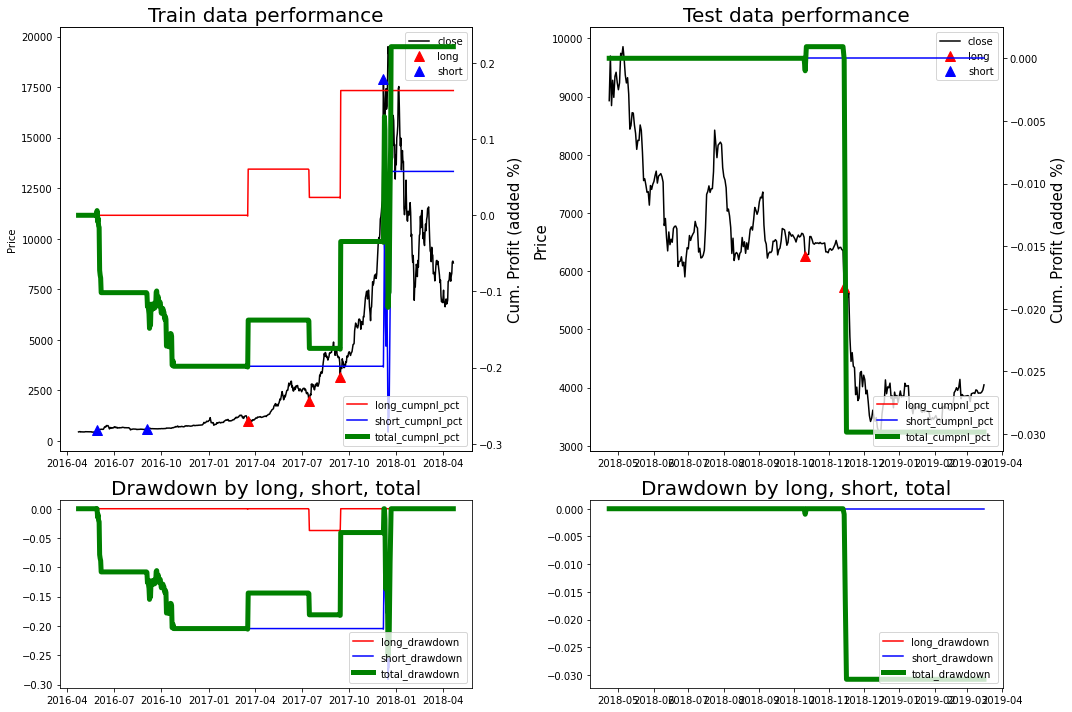

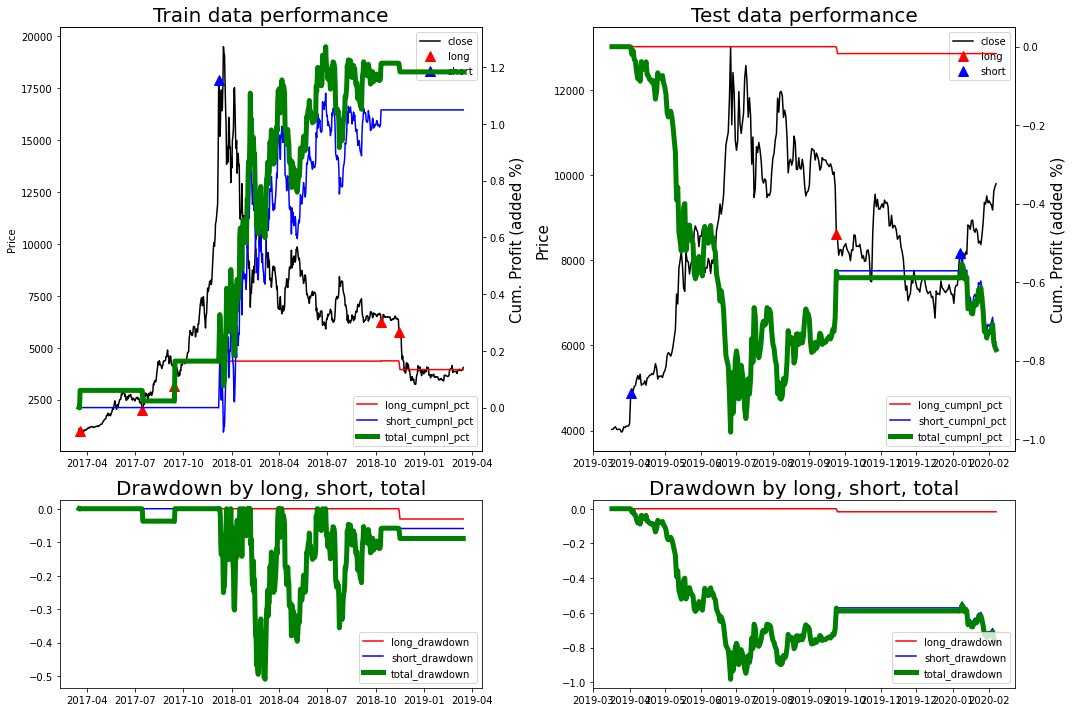

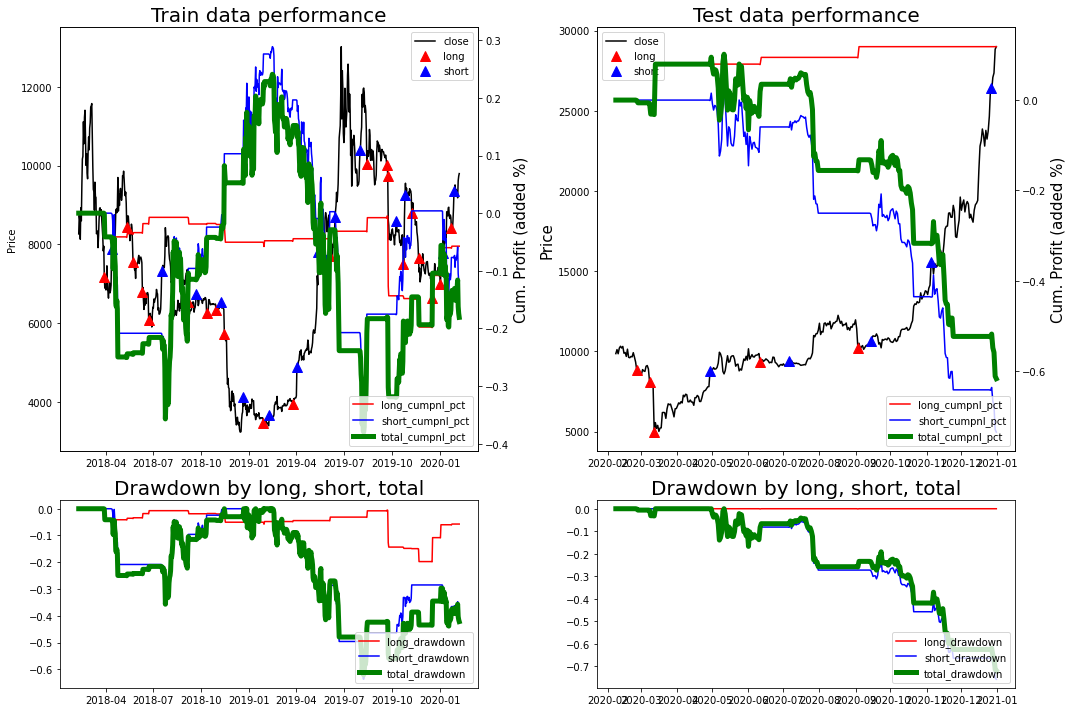

In [ ]:
for i in range(0,4):
  bollinger_trainresult_df = pd.read_csv('backtest_testresult_data/bollinger_trainresult_df_{}.csv'.format(i))
  bollinger_trainresult_df = bollinger_trainresult_df.set_index('Date')
  bollinger_trainresult_df.index = pd.to_datetime(bollinger_trainresult_df.index)

  bollinger_testresult_df = pd.read_csv('backtest_testresult_data/bollinger_testresult_df_{}.csv'.format(i))
  bollinger_testresult_df = bollinger_testresult_df.set_index('Date')
  bollinger_testresult_df.index = pd.to_datetime(bollinger_testresult_df.index)

  backTest.trainTestperformanceGraph(bollinger_trainresult_df, bollinger_testresult_df)

##### Twitter sentiment strategy

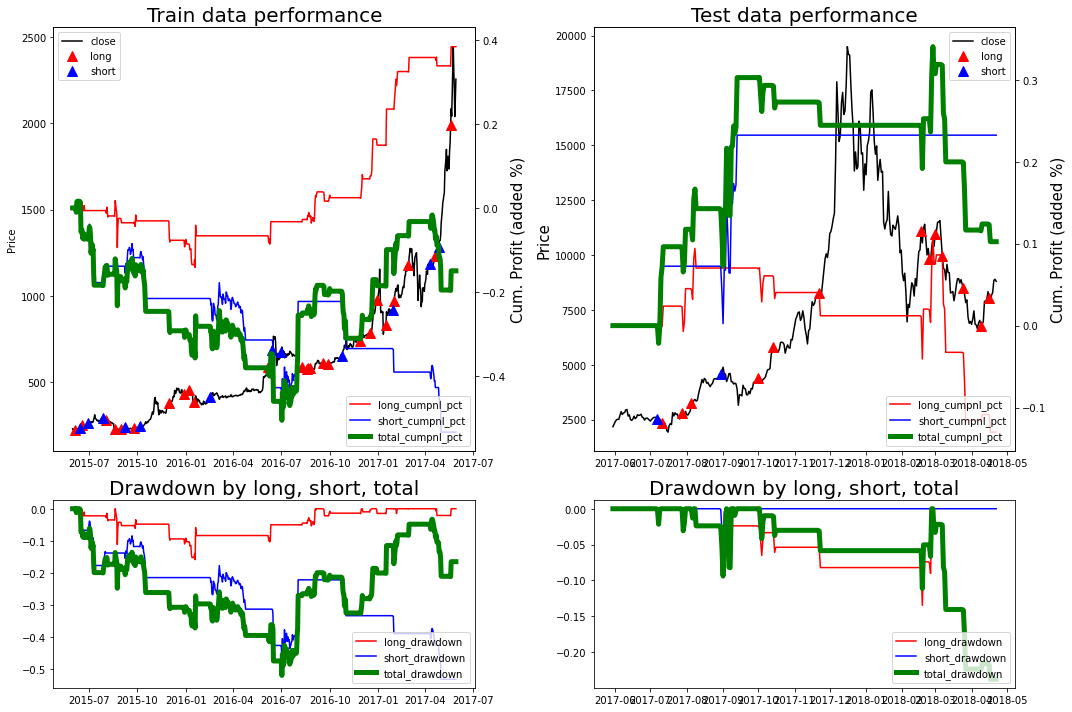

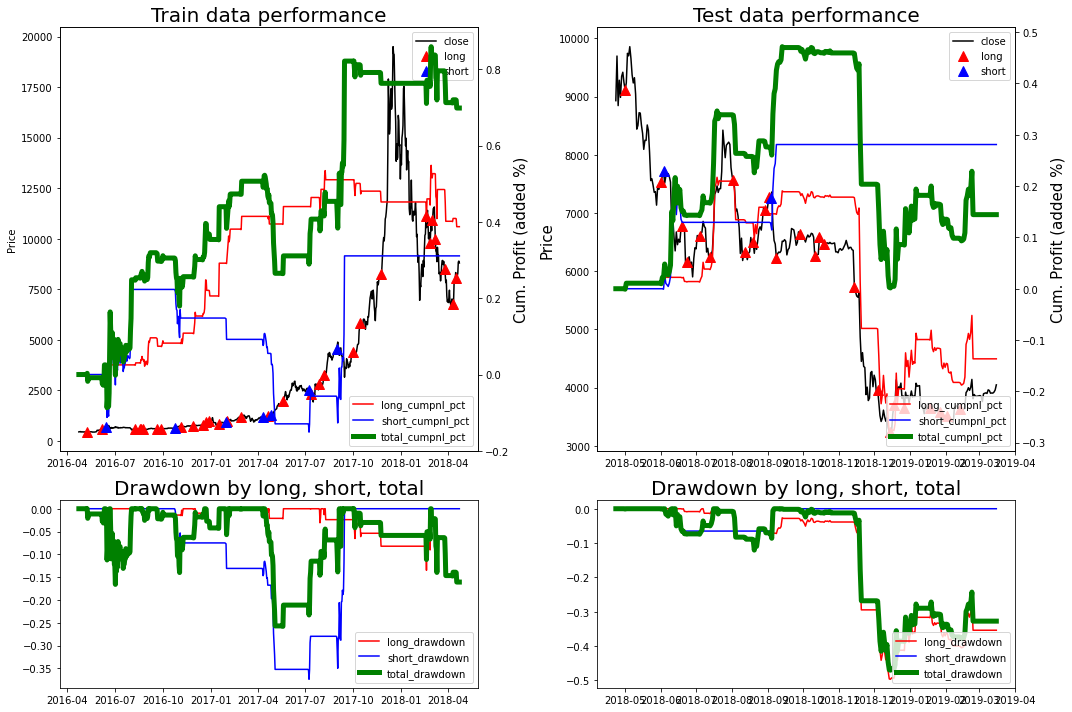

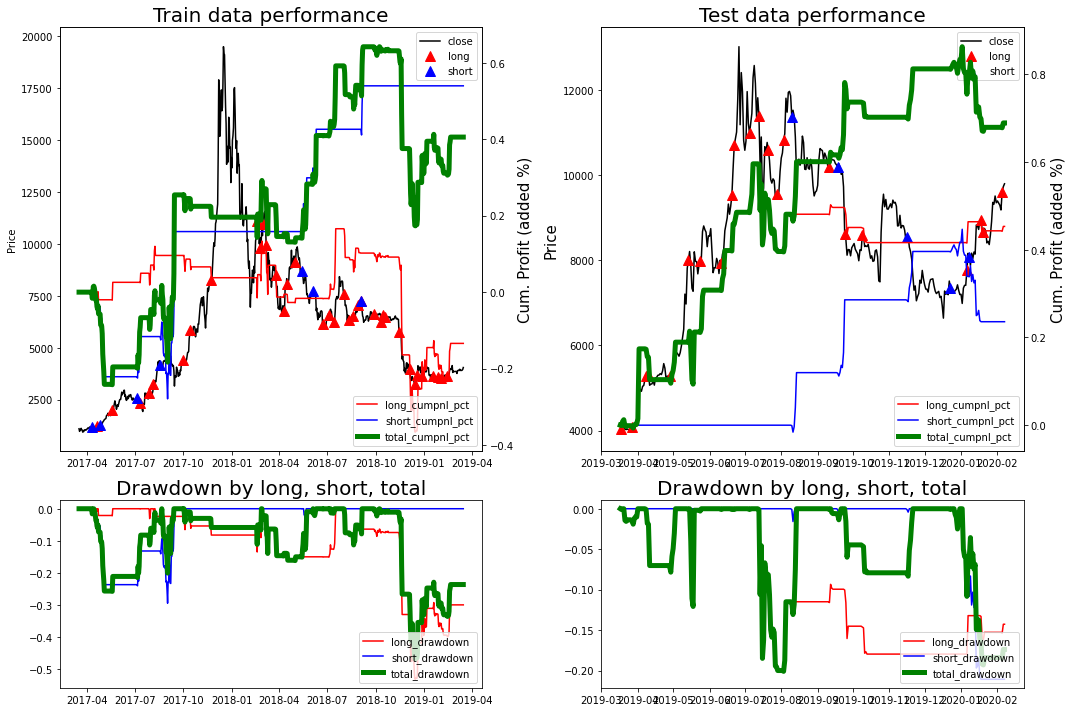

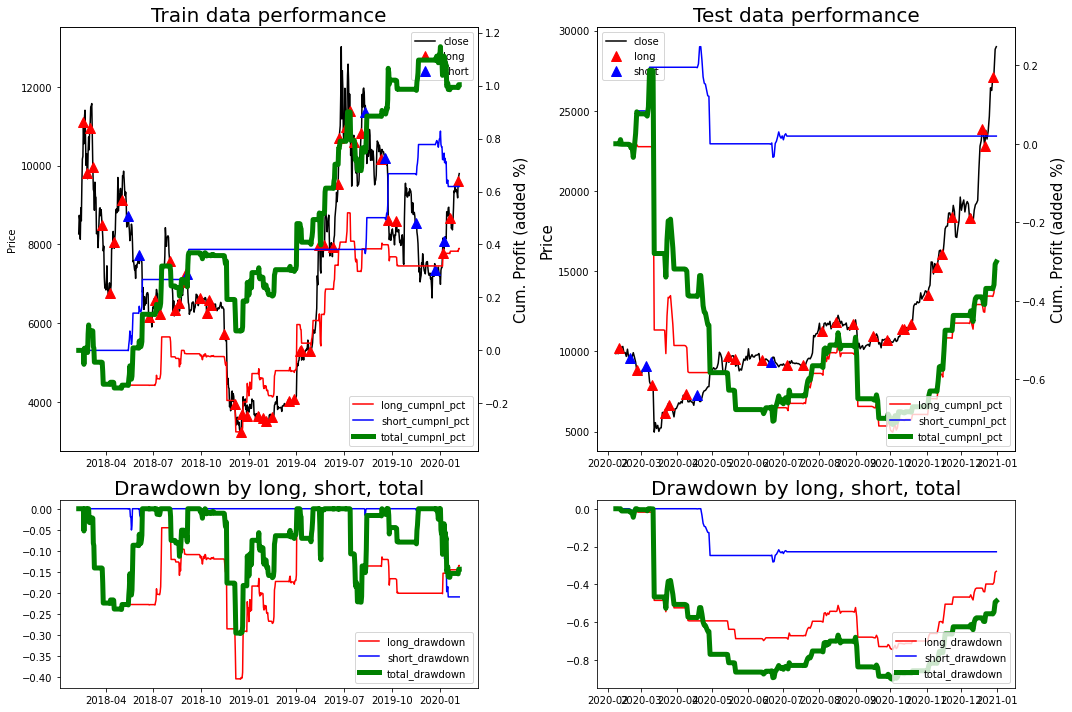

In [ ]:
for i in range(0,4):
  twitter_trainresult_df = pd.read_csv('backtest_testresult_data/twitter_trainresult_df_{}.csv'.format(i))
  twitter_trainresult_df = twitter_trainresult_df.set_index('Date')
  twitter_trainresult_df.index = pd.to_datetime(twitter_trainresult_df.index)

  twitter_testresult_df = pd.read_csv('backtest_testresult_data/twitter_testresult_df_{}.csv'.format(i))
  twitter_testresult_df = twitter_testresult_df.set_index('Date')
  twitter_testresult_df.index = pd.to_datetime(twitter_testresult_df.index)

  backTest.trainTestperformanceGraph(twitter_trainresult_df, twitter_testresult_df)

### Performance by strategies, connected by 4 test periods

In [ ]:
movingAvg_testresult_df = pd.read_csv('backtest_testresult_data/movingAvg_testresult_all_df.csv')
movingAvg_testresult_df = movingAvg_testresult_df.set_index('Date')
movingAvg_testresult_df.index = pd.to_datetime(movingAvg_testresult_df.index)
bollinger_testresult_df = pd.read_csv('backtest_testresult_data/bollinger_testresult_all_df.csv')
bollinger_testresult_df = bollinger_testresult_df.set_index('Date')
bollinger_testresult_df.index = pd.to_datetime(bollinger_testresult_df.index)
twitter_testresult_df = pd.read_csv('backtest_testresult_data/twitter_testresult_all_df.csv')
twitter_testresult_df = twitter_testresult_df.set_index('Date')
twitter_testresult_df.index = pd.to_datetime(twitter_testresult_df.index)

##### SMA strategy: Test data only

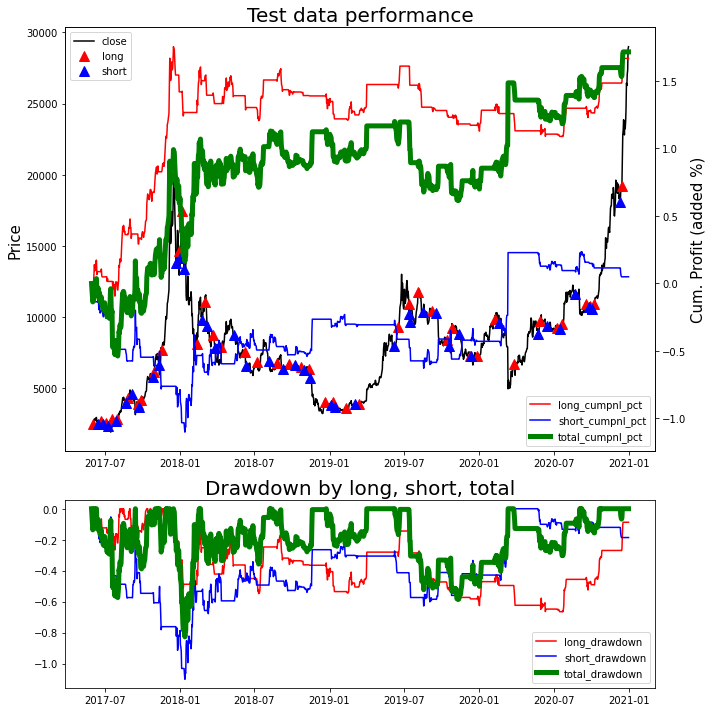

In [ ]:
backTest.allTestPerformanceGraph(movingAvg_testresult_df)

##### Bollinger Bands:Test data only

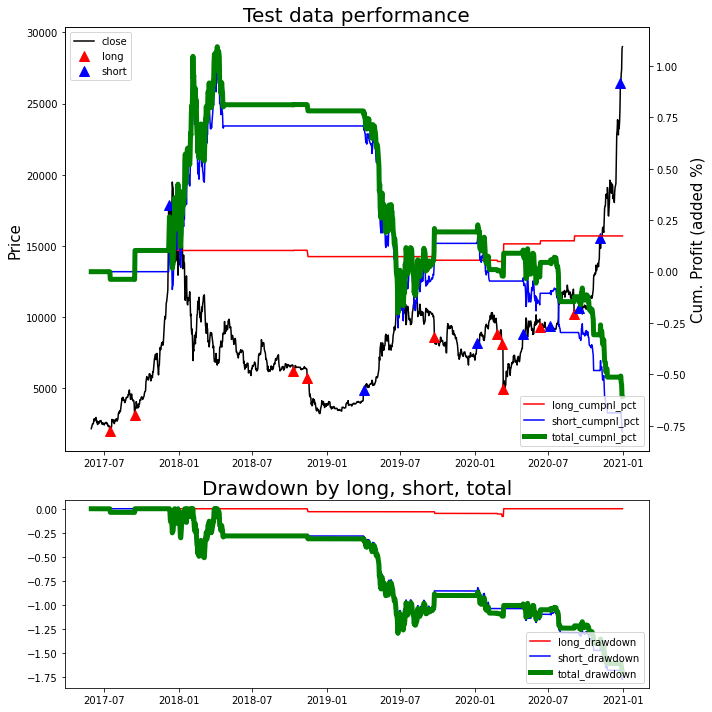

In [ ]:
backTest.allTestPerformanceGraph(bollinger_testresult_df)

##### Twitter sentiment strategy:Test data only

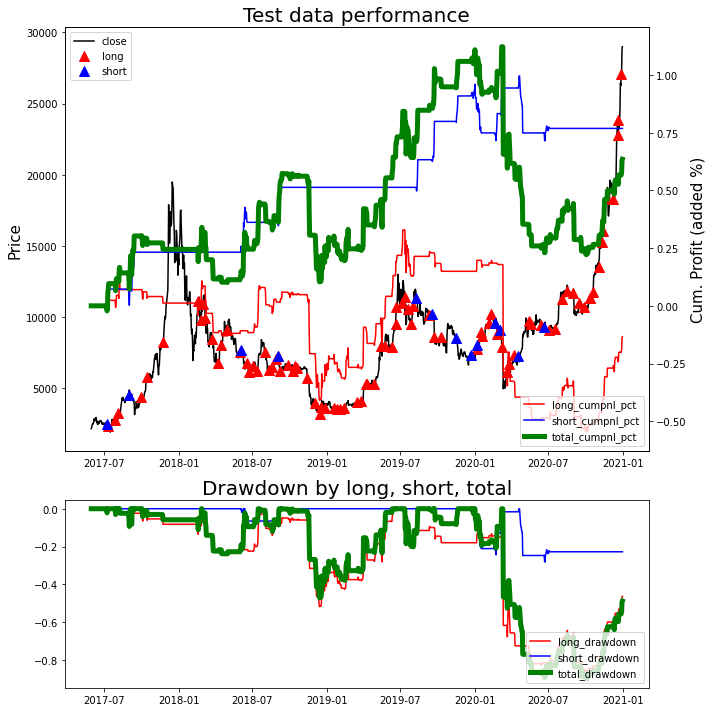

In [ ]:
backTest.allTestPerformanceGraph(twitter_testresult_df)